## Peak-Base, raw SCR value

### Phase 1 

In [330]:
import os

path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

import pandas as pd
import numpy as np

# Parameters
trialnumber = range(1, 13)  # Can adjust to first half of trials: range(1, 13)
excludeparticipants = 1  # Set to 0 to include all participants
rejtrials_threshold = 24  # Adjust the threshold as needed

# Load the table
peakstatstable = pd.read_csv('peak_stats_table-phase1.csv')

# Extract unique participant IDs and trial types
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Group data by participant
participant_groups = peakstatstable.groupby('sid')
dat = []

for participant_id in participants:
    data = participant_groups.get_group(participant_id)
    subject_data = {'subID': participant_id}

    # Process data if there are 24 trials
    if len(data) == 24:
        phase1_data = data[data['stNum'].isin(trialnumber)]

        # Rejected trials (based on "Publication recommendations for electrodermal measurements")
        rejTrials = phase1_data[phase1_data['phaBase2Peak'] < 0].index
        phase1_data.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0

        subject_data['rejTrials1'] = len(rejTrials)

        # Separate data by stim type
        stim_groups = phase1_data.groupby('stTy')

        try:
            # Calculate mean, SE, and count for CSS, CSR, and CS-
            css_data = stim_groups.get_group('CS+S')
            subject_data['meanCSS1'] = css_data['phaBase2Peak'].mean()
            subject_data['seCSS1'] = css_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSS1'] = len(css_data)

            csr_data = stim_groups.get_group('CS+R')
            subject_data['meanCSR1'] = csr_data['phaBase2Peak'].mean()
            subject_data['seCSR1'] = csr_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSR1'] = len(csr_data)

            csminus_data = stim_groups.get_group('CS-')
            subject_data['meanCSminus1'] = csminus_data['phaBase2Peak'].mean()
            subject_data['seCSminus1'] = csminus_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSminus1'] = len(csminus_data)

        except KeyError:
            print(f"Missing stim type data for participant {participant_id}")
        
    dat.append(subject_data)

# Convert to a DataFrame if you need a structured output
dat_df = pd.DataFrame(dat)
print(dat_df)


    subID  rejTrials1  meanCSS1    seCSS1  nCSS1  meanCSR1    seCSR1  nCSR1  \
0    N101           1   0.06800  0.033317      4   0.00550  0.004518      4   
1    N102           0   0.00275  0.002136      4   0.00075  0.000479      4   
2    N103           0   0.15100  0.008765      4   0.14000  0.053039      4   
3    N104           5   0.00050  0.000500      4   0.00075  0.000750      4   
4    N105           1   0.00825  0.002955      4   0.00125  0.001250      4   
..    ...         ...       ...       ...    ...       ...       ...    ...   
99   N255           5   0.00125  0.001250      4   0.00050  0.000500      4   
100  N257           1   0.05550  0.010037      4   0.08050  0.033310      4   
101  N258           0   0.04675  0.008499      4   0.04325  0.009707      4   
102  N259           0   0.02450  0.005694      4   0.02650  0.015113      4   
103  N260           0   0.11600  0.045067      4   0.09975  0.016080      4   

     meanCSminus1  seCSminus1  nCSminus1  
0       

#### CSR and CSS kept separate 

In [259]:
# intercept included cs- data, control data, placebo data see specific effect of drug, css, csr, etc. 

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 'CSR', 
    'meanCSS1': 'CSS', 
    'meanCSminus1': 'CSminus'
})

long_data['stim_type'] = long_data['stim_type'].astype('category')
long_data['stim_type'] = long_data['stim_type'].cat.reorder_categories(['CSminus', 'CSR', 'CSS'], ordered=True)

# Model formula including main effect of stim_type
model_formula = 'response ~ C(patient_group) + C(stim_type) + C(gender)'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     2.741
Date:                Tue, 05 Nov 2024   Prob (F-statistic):             0.0193
Time:                        12:27:23   Log-Likelihood:                 438.44
No. Observations:                 312   AIC:                            -864.9
Df Residuals:                     306   BIC:                            -842.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [260]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 1, 
    'meanCSS1': 2, 
    'meanCSminus1': 3
})

# Specify the model without intercept
model_formula = 'response ~ patient_group * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     3.226
Date:                Tue, 05 Nov 2024   Prob (F-statistic):             0.0129
Time:                        12:27:33   Log-Likelihood:                 438.03
No. Observations:                 312   AIC:                            -866.1
Df Residuals:                     307   BIC:                            -847.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60532/4197659941.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


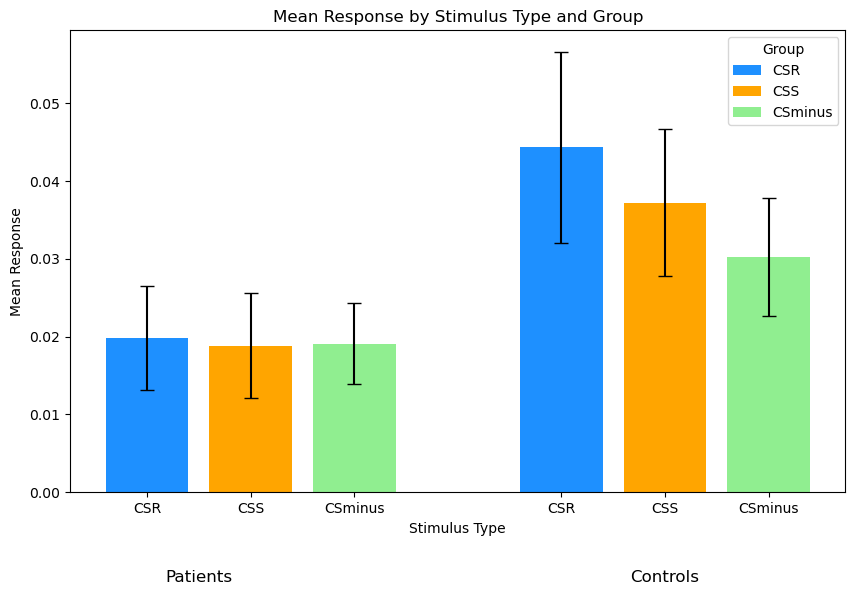

                           Comparison  t-statistic   p-value
0          patient-CSR vs patient-CSS     0.327856  0.744390
1      patient-CSR vs patient-CSminus     0.190048  0.850041
2      patient-CSS vs patient-CSminus    -0.084984  0.932613
3          control-CSR vs control-CSS     0.991623  0.325973
4      control-CSR vs control-CSminus     2.004761  0.050208
5      control-CSS vs control-CSminus     1.605303  0.114484
6          patient-CSR vs control-CSR    -1.755306  0.083032
7          patient-CSS vs control-CSS    -1.578381  0.117859
8  patient-CSminus vs control-CSminus    -1.207417  0.230381


In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 'CSR', 
    'meanCSS1': 'CSS', 
    'meanCSminus1': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CSR'): 0, ('patient', 'CSS'): 1, ('patient', 'CSminus'): 2,
    ('control', 'CSR'): 4, ('control', 'CSS'): 5, ('control', 'CSminus'): 6
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CSR': 'dodgerblue',
    'CSS': 'orange',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(10, 6))

for group in ['patient', 'control']:
    for stim in ['CSR', 'CSS', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Initialize table for storing t-test results
t_test_results = []

# Add significance markers
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
        
        # Store results in table
        t_test_results.append({
            'Comparison': f"{group1}-{stim1} vs {group2}-{stim2}",
            't-statistic': result.statistic,
            'p-value': result.pvalue
        })
        
        # Add markers if significant
        if result.pvalue < 0.05:  # Customize significance level if needed
            x1 = x_positions[(group1, stim1)]
            x2 = x_positions[(group2, stim2)]
            max_y = group_means['response'].max() + 0.025  # Adjust this if needed
            ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
            ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CSR'), ('patient', 'CSS')),   # Patient CSR vs CSS
    (('patient', 'CSR'), ('patient', 'CSminus')),  # Patient CSR vs CSminus
    (('patient', 'CSS'), ('patient', 'CSminus')),  # Patient CSS vs CSminus
    (('control', 'CSR'), ('control', 'CSS')),   # Control CSR vs CSS
    (('control', 'CSR'), ('control', 'CSminus')),  # Control CSR vs CSminus
    (('control', 'CSS'), ('control', 'CSminus')),  # Control CSS vs CSminus
    (('patient', 'CSR'), ('control', 'CSR')),    # Between-group CSR
    (('patient', 'CSS'), ('control', 'CSS')),    # Between-group CSS
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)
# Add x-axis labels to indicate groups
plt.text(0.5, -0.01, 'Patients', ha='center', va='top', fontsize=12)
plt.text(5, -0.01, 'Controls', ha='center', va='top', fontsize=12)

# Labeling and finalizing plot
plt.xticks([0, 1, 2, 4, 5, 6], ['CSR', 'CSS', 'CSminus', 'CSR', 'CSS', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response')
plt.title('Mean Response by Stimulus Type and Group')
plt.legend(title='Group')
plt.show()

# Display the table of t-test results
t_test_df = pd.DataFrame(t_test_results)
print(t_test_df)


#### CS+ vs CS-

In [322]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)  # 1 for patient, 0 for control
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Calculate the mean of CSR and CSS for each subject and create a new column for CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Count total, patient, and control subjects before filtering
total_subjects_before = len(merged_data)
patients_before = merged_data['patient_group'].sum()
controls_before = total_subjects_before - patients_before

# Filter subjects where CS_plus - meanCSminus1 > 0
filtered_data = merged_data[merged_data['CS_plus'] - merged_data['meanCSminus1'] > 0]

# Count total, patient, and control subjects after filtering
total_subjects_after = len(filtered_data)
patients_after = filtered_data['patient_group'].sum()
controls_after = total_subjects_after - patients_after

# Calculate exclusions
excluded_total = total_subjects_before - total_subjects_after
excluded_patients = patients_before - patients_after
excluded_controls = controls_before - controls_after

# Calculate exclusion percentages
excluded_total_pct = (excluded_total / total_subjects_before) * 100
excluded_patients_pct = (excluded_patients / patients_before) * 100 if patients_before > 0 else 0
excluded_controls_pct = (excluded_controls / controls_before) * 100 if controls_before > 0 else 0

print(f"Total subjects excluded: {excluded_total} ({excluded_total_pct:.2f}%)")
print(f"Patients excluded: {excluded_patients} ({excluded_patients_pct:.2f}%)")
print(f"Controls excluded: {excluded_controls} ({excluded_controls_pct:.2f}%)")

# Proceed with the analysis on filtered_data
# Reshape data to stack CS_plus and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['CS_plus', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'CS_plus': 1, 
    'meanCSminus1': 0
})

# Specify the model without intercept
model_formula = 'response ~ patient_group * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


Total subjects excluded: 40 (38.46%)
Patients excluded: 17 (33.33%)
Controls excluded: 23 (43.40%)
                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.994
Date:                Tue, 05 Nov 2024   Prob (F-statistic):             0.0967
Time:                        13:55:30   Log-Likelihood:                 214.37
No. Observations:                 208   AIC:                            -418.7
Df Residuals:                     203   BIC:                            -402.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60532/966323264.py:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


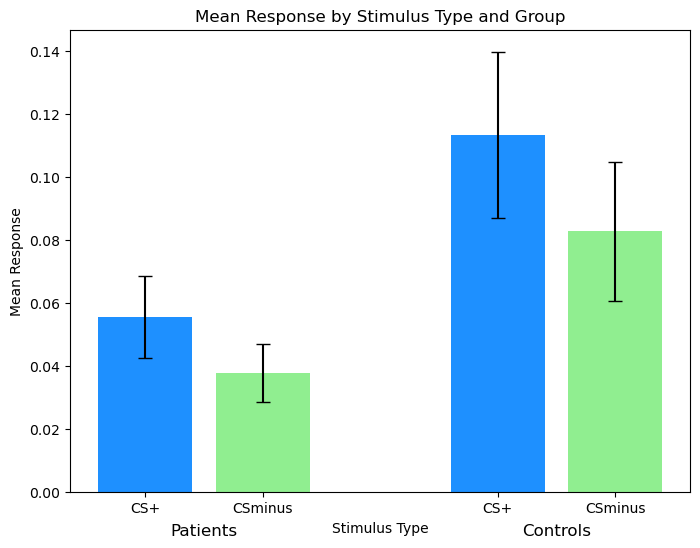

           Group 1          Group 2  t-statistic   p-value           Test Type
0      patient CS+  patient CSminus     3.601029  0.001028       Paired t-test
1      control CS+  control CSminus     3.192318  0.003384       Paired t-test
2      patient CS+      control CS+    -1.964039  0.056100  Independent t-test
3  patient CSminus  control CSminus    -1.869180  0.069158  Independent t-test


In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate the mean of CSR and CSS for each subject to create CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Filter subjects where CS_plus - meanCSminus1 > 0
filtered_data = merged_data[merged_data['CS_plus'] - merged_data['meanCSminus1'] > 0]

# # Count total, patient, and control subjects after filtering
# total_subjects_after = len(filtered_data)
# patients_after = filtered_data['patient_group'].sum()
# controls_after = total_subjects_after - patients_after

# # Calculate exclusions
# excluded_total = total_subjects_before - total_subjects_after
# excluded_patients = patients_before - patients_after
# excluded_controls = controls_before - controls_after

# # Calculate exclusion percentages
# excluded_total_pct = (excluded_total / total_subjects_before) * 100
# excluded_patients_pct = (excluded_patients / patients_before) * 100 if patients_before > 0 else 0
# excluded_controls_pct = (excluded_controls / controls_before) * 100 if controls_before > 0 else 0

# print(f"Total subjects excluded: {excluded_total} ({excluded_total_pct:.2f}%)")
# print(f"Patients excluded: {excluded_patients} ({excluded_patients_pct:.2f}%)")
# print(f"Controls excluded: {excluded_controls} ({excluded_controls_pct:.2f}%)")

# Reshape data to stack CS_plus and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(filtered_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['CS_plus', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'CS_plus': 'CS+', 
    'meanCSminus1': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CS+'): 0, ('patient', 'CSminus'): 1,
    ('control', 'CS+'): 3, ('control', 'CSminus'): 4
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CS+': 'dodgerblue',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(8, 6))

for group in ['patient', 'control']:
    for stim in ['CS+', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Initialize DataFrame to store t-test results
ttest_results = []

# Add significance markers and collect t-test results
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
            test_type = 'Paired t-test'
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
            test_type = 'Independent t-test'
        
        # Store t-test results
        ttest_results.append({
            'Group 1': f"{group1} {stim1}",
            'Group 2': f"{group2} {stim2}",
            't-statistic': result.statistic,
            'p-value': result.pvalue,
            'Test Type': test_type
        })
        
        # if result.pvalue < 0.05:  # Customize significance level if needed
        #     x1 = x_positions[(group1, stim1)]
        #     x2 = x_positions[(group2, stim2)]
        #     max_y = group_means['response'].max() + 0.025  # Adjust this if needed
        #     ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
        #     ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CS+'), ('patient', 'CSminus')),   # Patient CS+ vs CSminus
    (('control', 'CS+'), ('control', 'CSminus')),   # Control CS+ vs CSminus
    (('patient', 'CS+'), ('control', 'CS+')),       # Between-group CS+
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)

# Labeling and finalizing plot
plt.xticks([0, 1, 3, 4], ['CS+', 'CSminus', 'CS+', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response')
plt.title('Mean Response by Stimulus Type and Group')

# Add x-axis labels to indicate groups
plt.text(0.5, -0.01, 'Patients', ha='center', va='top', fontsize=12)
plt.text(3.5, -0.01, 'Controls', ha='center', va='top', fontsize=12)

# plt.legend(title='Stimulus Type',loc='left')
plt.show()

# Create DataFrame from t-test results and print
ttest_results_df = pd.DataFrame(ttest_results)
print(ttest_results_df)


Patients (CSplus - CSminus) t-test: t = 1.272, p = 0.209
Controls (CSplus - CSminus) t-test: t = 2.196, p = 0.033
Between-group t-test (CSplus - CSminus): t = -0.652, p = 0.516


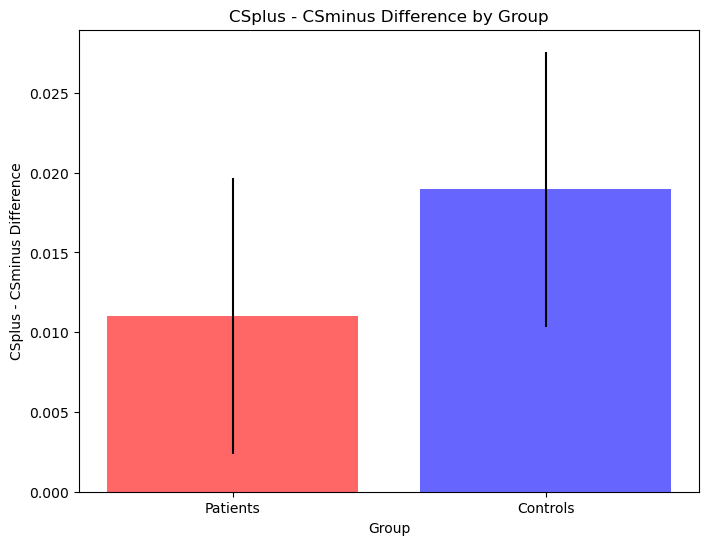

In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate the mean of CSR and CSS for each subject to create CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Calculate CSplus - CSminus for each participant
merged_data['CS_diff'] = merged_data['CS_plus'] - merged_data['meanCSminus1']

# Separate data for each group
patient_data = merged_data[merged_data['patient_group'] == 'patient']['CS_diff']
control_data = merged_data[merged_data['patient_group'] == 'control']['CS_diff']

# Plot the CSplus - CSminus difference for each group
plt.figure(figsize=(8, 6))

# Define bar positions and colors
positions = [0, 1]
colors = ['red', 'blue']

# Plot bars
plt.bar(positions[0], patient_data.mean(), yerr=stats.sem(patient_data), color=colors[0],alpha=0.6, label='Patients')
plt.bar(positions[1], control_data.mean(), yerr=stats.sem(control_data), color=colors[1],alpha=0.6, label='Controls')

# Add t-test results to the plot
# One-sample t-tests for each group
t_patient, p_patient = stats.ttest_1samp(patient_data, 0)
t_control, p_control = stats.ttest_1samp(control_data, 0)

# Independent t-test between groups
t_between, p_between = stats.ttest_ind(patient_data, control_data, equal_var=False)

# Print t-test results
print(f"Patients (CSplus - CSminus) t-test: t = {t_patient:.3f}, p = {p_patient:.3f}")
print(f"Controls (CSplus - CSminus) t-test: t = {t_control:.3f}, p = {p_control:.3f}")
print(f"Between-group t-test (CSplus - CSminus): t = {t_between:.3f}, p = {p_between:.3f}")

# # Annotate significance on the plot if p < 0.05
# max_y = max(patient_data.mean(), control_data.mean()) + 0.1
# if p_patient < 0.05:
#     plt.text(positions[0], max_y, '*', ha='center', fontsize=14)
# if p_control < 0.05:
#     plt.text(positions[1], max_y, '*', ha='center', fontsize=14)
# if p_between < 0.05:
#     plt.plot(positions, [max_y + 0.05, max_y + 0.05], 'k-', lw=1)
#     plt.text(sum(positions)/2, max_y + 0.06, '*', ha='center', fontsize=14)

# Finalize the plot
plt.xticks(positions, ['Patients', 'Controls'])
plt.xlabel('Group')
plt.ylabel('CSplus - CSminus Difference')
plt.title('CSplus - CSminus Difference by Group')
# plt.legend()
plt.show()


Patients (CSplus - CSminus) t-test: t = 1.111, p = 0.272
Controls (CSplus - CSminus) t-test: t = 2.150, p = 0.036
Between-group t-test (CSplus - CSminus): t = -0.709, p = 0.480


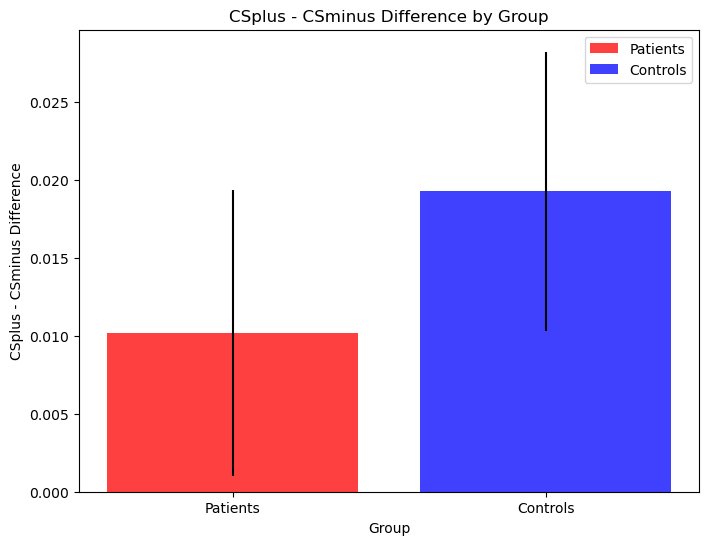

In [332]:
### excluding sub-clinical LSAS (removing 3 SAD, 2 HC) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Exclude specific subjects
excluded_subjects = ['N114', 'N118', 'N121', 'N238', 'N251']
merged_data = merged_data[~merged_data['subID'].isin(excluded_subjects)]

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate the mean of CSR and CSS for each subject to create CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Calculate CSplus - CSminus for each participant
merged_data['CS_diff'] = merged_data['CS_plus'] - merged_data['meanCSminus1']

# Separate data for each group
patient_data = merged_data[merged_data['patient_group'] == 'patient']['CS_diff']
control_data = merged_data[merged_data['patient_group'] == 'control']['CS_diff']

# Plot the CSplus - CSminus difference for each group
plt.figure(figsize=(8, 6))

# Define bar positions and colors
positions = [0, 1]
colors = ['red', 'blue']

# Plot bars
plt.bar(positions[0], patient_data.mean(), yerr=stats.sem(patient_data), color=colors[0],alpha = 0.75, label='Patients')
plt.bar(positions[1], control_data.mean(), yerr=stats.sem(control_data), color=colors[1], alpha = 0.75, label='Controls')

# Add t-test results to the plot
# One-sample t-tests for each group
t_patient, p_patient = stats.ttest_1samp(patient_data, 0)
t_control, p_control = stats.ttest_1samp(control_data, 0)

# Independent t-test between groups
t_between, p_between = stats.ttest_ind(patient_data, control_data, equal_var=False)

# Print t-test results
print(f"Patients (CSplus - CSminus) t-test: t = {t_patient:.3f}, p = {p_patient:.3f}")
print(f"Controls (CSplus - CSminus) t-test: t = {t_control:.3f}, p = {p_control:.3f}")
print(f"Between-group t-test (CSplus - CSminus): t = {t_between:.3f}, p = {p_between:.3f}")

# # Annotate significance on the plot if p < 0.05
# max_y = max(patient_data.mean(), control_data.mean()) + 0.1
# if p_patient < 0.05:
#     plt.text(positions[0], max_y, '*', ha='center', fontsize=14)
# if p_control < 0.05:
#     plt.text(positions[1], max_y, '*', ha='center', fontsize=14)
# if p_between < 0.05:
#     plt.plot(positions, [max_y + 0.05, max_y + 0.05], 'k-', lw=1)
#     plt.text(sum(positions)/2, max_y + 0.06, '*', ha='center', fontsize=14)

# Finalize the plot
plt.xticks(positions, ['Patients', 'Controls'])
plt.xlabel('Group')
plt.ylabel('CSplus - CSminus Difference')
plt.title('CSplus - CSminus Difference by Group')
plt.legend()
plt.show()


Patients excluded due to outliers: 10 (20.83%) out of 48
Controls excluded due to outliers: 10 (19.61%) out of 51
Patients (CSplus - CSminus) t-test: t = 1.612, p = 0.115
Controls (CSplus - CSminus) t-test: t = -0.255, p = 0.800
Between-group t-test (CSplus - CSminus): t = 1.465, p = 0.148


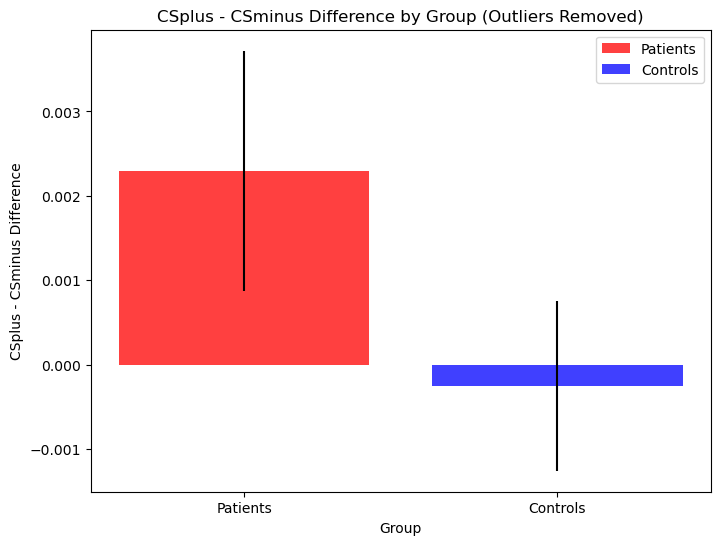

In [328]:
### also w outlier removal 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Exclude specific subjects
excluded_subjects = ['N114', 'N118', 'N121', 'N238', 'N251']
merged_data = merged_data[~merged_data['subID'].isin(excluded_subjects)]

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate the mean of CSR and CSS for each subject to create CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Calculate CSplus - CSminus for each participant
merged_data['CS_diff'] = merged_data['CS_plus'] - merged_data['meanCSminus1']

# Define a function to remove outliers using IQR and return outlier-free data along with count of exclusions
def remove_outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    exclusions = len(data) - len(filtered_data)
    return filtered_data, exclusions

# Apply outlier removal to each group and calculate exclusions
initial_patient_count = len(merged_data[merged_data['patient_group'] == 'patient'])
initial_control_count = len(merged_data[merged_data['patient_group'] == 'control'])

patient_data, patient_exclusions = remove_outliers(merged_data[merged_data['patient_group'] == 'patient']['CS_diff'])
control_data, control_exclusions = remove_outliers(merged_data[merged_data['patient_group'] == 'control']['CS_diff'])

# Calculate exclusion percentages
patient_exclusion_pct = (patient_exclusions / initial_patient_count) * 100
control_exclusion_pct = (control_exclusions / initial_control_count) * 100

# Print exclusion stats
print(f"Patients excluded due to outliers: {patient_exclusions} ({patient_exclusion_pct:.2f}%) out of {initial_patient_count}")
print(f"Controls excluded due to outliers: {control_exclusions} ({control_exclusion_pct:.2f}%) out of {initial_control_count}")

# Plot the CSplus - CSminus difference for each group
plt.figure(figsize=(8, 6))

# Define bar positions and colors
positions = [0, 1]
colors = ['red', 'blue']

# Plot bars
plt.bar(positions[0], patient_data.mean(), yerr=stats.sem(patient_data), color=colors[0],alpha = 0.75, label='Patients')
plt.bar(positions[1], control_data.mean(), yerr=stats.sem(control_data), color=colors[1], alpha=0.75, label='Controls')

# Add t-test results to the plot
# One-sample t-tests for each group
t_patient, p_patient = stats.ttest_1samp(patient_data, 0)
t_control, p_control = stats.ttest_1samp(control_data, 0)

# Independent t-test between groups
t_between, p_between = stats.ttest_ind(patient_data, control_data, equal_var=False)

# Print t-test results
print(f"Patients (CSplus - CSminus) t-test: t = {t_patient:.3f}, p = {p_patient:.3f}")
print(f"Controls (CSplus - CSminus) t-test: t = {t_control:.3f}, p = {p_control:.3f}")
print(f"Between-group t-test (CSplus - CSminus): t = {t_between:.3f}, p = {p_between:.3f}")

# # Annotate significance on the plot if p < 0.05
# max_y = max(patient_data.mean(), control_data.mean()) + 0.1
# if p_patient < 0.05:
#     plt.text(positions[0], max_y, '*', ha='center', fontsize=14)
# if p_control < 0.05:
#     plt.text(positions[1], max_y, '*', ha='center', fontsize=14)
# if p_between < 0.05:
#     plt.plot(positions, [max_y + 0.05, max_y + 0.05], 'k-', lw=1)
#     plt.text(sum(positions)/2, max_y + 0.06, '*', ha='center', fontsize=14)

# Finalize the plot
plt.xticks(positions, ['Patients', 'Controls'])
plt.xlabel('Group')
plt.ylabel('CSplus - CSminus Difference')
plt.title('CSplus - CSminus Difference by Group (Outliers Removed)')
plt.legend()
plt.show()


Patients excluded due to outliers: 10 (19.61%) out of 51
Controls excluded due to outliers: 10 (18.87%) out of 53
Patients (CSplus - CSminus) t-test: t = 2.145, p = 0.038
Controls (CSplus - CSminus) t-test: t = 0.355, p = 0.724
Between-group t-test (CSplus - CSminus): t = 1.464, p = 0.147


/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60532/1677514447.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_data = merged_data.groupby('patient_group').apply(


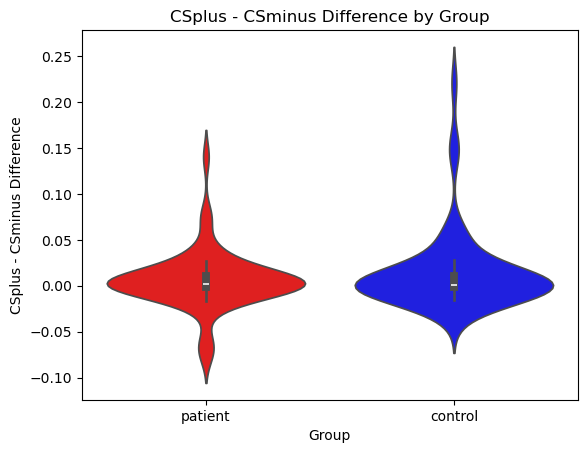

In [329]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# # Exclude specific subjects
# excluded_subjects = ['N114', 'N118', 'N121', 'N238', 'N251']
# merged_data = merged_data[~merged_data['subID'].isin(excluded_subjects)]

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate the mean of CSR and CSS for each subject to create CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Calculate CSplus - CSminus for each participant
merged_data['CS_diff'] = merged_data['CS_plus'] - merged_data['meanCSminus1']

### Outlier removal
def remove_outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (data >= lower_bound) & (data <= upper_bound)

# Apply outlier removal to each group
filtered_data = merged_data.groupby('patient_group').apply(
    lambda x: x[remove_outliers(x['CS_diff']).values]
).reset_index(drop=True)

# Calculate exclusions
initial_counts = merged_data.groupby('patient_group').size()
final_counts = filtered_data.groupby('patient_group').size()
exclusions = initial_counts - final_counts
exclusion_pct = (exclusions / initial_counts * 100).round(2)

# Print exclusion stats
print(f"Patients excluded due to outliers: {exclusions['patient']} ({exclusion_pct['patient']}%) out of {initial_counts['patient']}")
print(f"Controls excluded due to outliers: {exclusions['control']} ({exclusion_pct['control']}%) out of {initial_counts['control']}")

# Plot using Seaborn catplot
# sns.catplot(
#     data=merged_data,
#     # data=filtered_data, #uncomment for outlier removal
#     x='patient_group',
#     y='CS_diff',
#     kind='strip',
#     hue='patient_group',
#     dodge=True,
#     palette={'patient': 'red', 'control': 'blue'}
# )

sns.violinplot(
    data=merged_data,
    # data=filtered_data, #uncomment for outlier removal
    x='patient_group',
    y='CS_diff',
    hue='patient_group',
    palette={'patient': 'red', 'control': 'blue'}
)
plt.xlabel('Group')
plt.ylabel('CSplus - CSminus Difference')
plt.title('CSplus - CSminus Difference by Group')

# Run t-tests on the filtered data
patient_data = filtered_data[filtered_data['patient_group'] == 'patient']['CS_diff']
control_data = filtered_data[filtered_data['patient_group'] == 'control']['CS_diff']

# One-sample t-tests for each group
t_patient, p_patient = stats.ttest_1samp(patient_data, 0)
t_control, p_control = stats.ttest_1samp(control_data, 0)

# Independent t-test between groups
t_between, p_between = stats.ttest_ind(patient_data, control_data, equal_var=False)

# Display t-test results
print(f"Patients (CSplus - CSminus) t-test: t = {t_patient:.3f}, p = {p_patient:.3f}")
print(f"Controls (CSplus - CSminus) t-test: t = {t_control:.3f}, p = {p_control:.3f}")
print(f"Between-group t-test (CSplus - CSminus): t = {t_between:.3f}, p = {p_between:.3f}")

plt.show()


### Phase 2 / 3 - averaged across the whole phase

In [469]:
import pandas as pd
import numpy as np

# Parameters to adjust:
trialnumber2 = range(1, 25)  # Adjust this range to analyze specific trials (e.g., first half = range(1, 13))
trialnumber3 = range(25, 37) # Adjust this range for phase 3 analysis (e.g., range(25, 37) for first half)

excludeparticipants = 1  # Set to 0 to include all subjects; if set to 1, participants with rejected trials >= rejtrials_threshold are excluded
rejtrials_threshold = 24  # Threshold for trial rejection; adjust according to trial number

# Load data
peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv')
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Separate data by participant, phase, and stim type
grouped_data = peakstatstable.groupby('sid')
dat = []

for participant in participants:
    data = grouped_data.get_group(participant)
    participant_data = {'subID': participant}

    # Ensuring consistent data structure
    if data.shape[0] == 48:
        
        # Phase 2 processing: stims numbered in trialnumber2
        phase2_data = data[data['stNum'].isin(trialnumber2)]
        rejTrials = phase2_data[phase2_data['phaBase2Peak'] < 0.02].index
        phase2_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials2'] = len(rejTrials)

        # Separate out stim types
        data2 = {key: value for key, value in phase2_data.groupby('stTy')}
        try:
            participant_data['meanCSS2'] = data2['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2'] = data2['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2['CS+S']))
            participant_data['nCSS2'] = len(data2['CS+S'])
            participant_data['meanCSR2'] = data2['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2'] = data2['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2['CS+R']))
            participant_data['nCSR2'] = len(data2['CS+R'])
            participant_data['meanCSminus2'] = data2['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2'] = data2['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2['CS-']))
            participant_data['nCSminus2'] = len(data2['CS-'])
        except KeyError:
            # Handle missing data if any stimulus type is not present for a participant
            print(f"Missing data for participant {participant} in Phase 2.")

        # Phase 3 processing: stims numbered in trialnumber3
        phase3_data = data[data['stNum'].isin(trialnumber3)]
        rejTrials = phase3_data[phase3_data['phaBase2Peak'] < 0.02].index
        phase3_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials3'] = len(rejTrials)

        # Separate out stim types
        data3 = {key: value for key, value in phase3_data.groupby('stTy')}
        try:
            participant_data['meanCSS3'] = data3['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3'] = data3['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3['CS+S']))
            participant_data['nCSS3'] = len(data3['CS+S'])
            participant_data['meanCSR3'] = data3['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3'] = data3['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3['CS+R']))
            participant_data['nCSR3'] = len(data3['CS+R'])
            participant_data['meanCSminus3'] = data3['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3'] = data3['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3['CS-']))
            participant_data['nCSminus3'] = len(data3['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3.")

    # Add participant data to the main list
    dat.append(participant_data)

# Convert dat list to a DataFrame for easier viewing and export
dat_df = pd.DataFrame(dat)
print(dat_df)


    subID  rejTrials2  meanCSS2    seCSS2  nCSS2  meanCSR2    seCSR2  nCSR2  \
0    N101           3  0.020250  0.002957      8  0.031750  0.010813      8   
1    N103           4  0.032625  0.003105      8  0.024875  0.013315      8   
2    N104           4  0.016125  0.003543      8  0.016000  0.003505      8   
3    N105           5  0.018000  0.003973      8  0.020000  0.002928      8   
4    N106           0  0.025000  0.001000      8  0.027625  0.002104      8   
..    ...         ...       ...       ...    ...       ...       ...    ...   
96   N255           0  0.032500  0.002228      8  0.034625  0.004263      8   
97   N257           3  0.020500  0.002958      8  0.020125  0.002900      8   
98   N258           0  0.029625  0.000885      8  0.029500  0.000945      8   
99   N259           0  0.032250  0.000590      8  0.031375  0.000420      8   
100  N260          11  0.023125  0.009516      8  0.054875  0.022743      8   

     meanCSminus2  seCSminus2  ...  rejTrials3  mea

#### Extinction

In [379]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR2', 'meanCSS2', 'meanCSminus2'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR2': 1, 
    'meanCSS2': 2, 
    'meanCSminus2': 3
})

# Specify the model without intercept
model_formula = 'response ~ patient_group * drug * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.074
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.381
Time:                        08:22:40   Log-Likelihood:                 448.71
No. Observations:                 303   AIC:                            -879.4
Df Residuals:                     294   BIC:                            -846.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60532/639515244.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


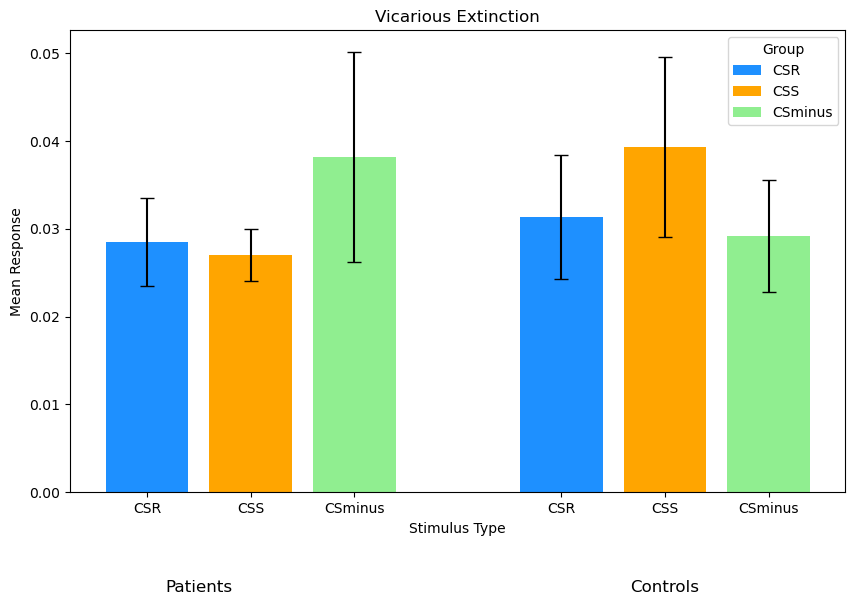

In [380]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['meanCSR2', 'meanCSS2', 'meanCSminus2'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR2': 'CSR', 
    'meanCSS2': 'CSS', 
    'meanCSminus2': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CSR'): 0, ('patient', 'CSS'): 1, ('patient', 'CSminus'): 2,
    ('control', 'CSR'): 4, ('control', 'CSS'): 5, ('control', 'CSminus'): 6
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CSR': 'dodgerblue',
    'CSS': 'orange',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(10, 6))

for group in ['patient', 'control']:
    for stim in ['CSR', 'CSS', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Add significance markers
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
        
        if result.pvalue < 0.05:  # Customize significance level if needed
            x1 = x_positions[(group1, stim1)]
            x2 = x_positions[(group2, stim2)]
            max_y = group_means['response'].max() + 0.025  # Adjust this if needed
            ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
            ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CSR'), ('patient', 'CSS')),   # Patient CSR vs CSS
    (('patient', 'CSR'), ('patient', 'CSminus')),  # Patient CSR vs CSminus
    (('patient', 'CSS'), ('patient', 'CSminus')),  # Patient CSS vs CSminus
    (('control', 'CSR'), ('control', 'CSS')),   # Control CSR vs CSS
    (('control', 'CSR'), ('control', 'CSminus')),  # Control CSR vs CSminus
    (('control', 'CSS'), ('control', 'CSminus')),  # Control CSS vs CSminus
    (('patient', 'CSR'), ('control', 'CSR')),    # Between-group CSR
    (('patient', 'CSS'), ('control', 'CSS')),    # Between-group CSS
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)
# Add x-axis labels to indicate groups
plt.text(0.5, -0.01, 'Patients', ha='center', va='top', fontsize=12)
plt.text(5, -0.01, 'Controls', ha='center', va='top', fontsize=12)

# Labeling and finalizing plot
plt.xticks([0, 1, 2, 4, 5, 6], ['CSR', 'CSS', 'CSminus', 'CSR', 'CSS', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response')
plt.title('Vicarious Extinction')
plt.legend(title='Group')
plt.show()


In [381]:
#### just placebo condition! 

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Filter to include only individuals in the placebo condition (drug_order = 0)
merged_data = merged_data[merged_data['drug_condition'] == 0]

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group',  'gender'], 
                    value_vars=['meanCSR2', 'meanCSS2', 'meanCSminus2'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR2': 1, 
    'meanCSS2': 2, 
    'meanCSminus2': 3
})

# Specify the model without intercept
model_formula = 'response ~ patient_group * stim_type'  # Removed 'drug' from model since all are placebo

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.026
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.383
Time:                        08:23:09   Log-Likelihood:                 210.99
No. Observations:                 150   AIC:                            -414.0
Df Residuals:                     146   BIC:                            -401.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60532/83951097.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


In [338]:
merged_data.shape

(50, 27)

Patient group CSR-CSS vs 0: t = -0.05, p = 0.964
Control group CSR-CSS vs 0: t = -2.10, p = 0.045
Between-group CSR-CSS comparison: t = 1.84, p = 0.074


/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60532/1306985894.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='patient_group', y='CSR_CSS', errorbar='se', palette=['red', 'blue'],alpha = 0.75)


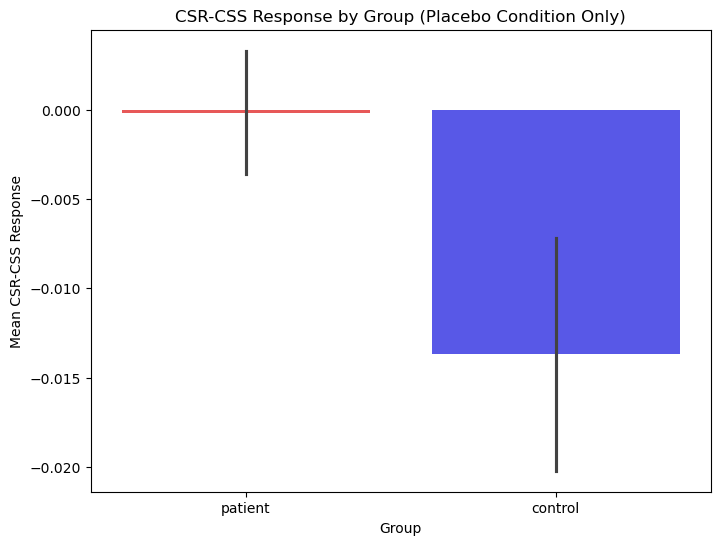

In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Filter to include only individuals in the placebo condition (drug_order = 0)
merged_data = merged_data[merged_data['drug_condition'] == 0]

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate CSR-CSS difference
merged_data['CSR_CSS'] = merged_data['meanCSR2'] - merged_data['meanCSS2']

# Extract data for plotting
plot_data = merged_data[['subID', 'patient_group', 'CSR_CSS']]

# Plot the CSR-CSS response by group
plt.figure(figsize=(8, 6))
sns.barplot(data=plot_data, x='patient_group', y='CSR_CSS', errorbar='se', palette=['red', 'blue'],alpha = 0.75)

# Add labels
plt.xlabel('Group')
plt.ylabel('Mean CSR-CSS Response')
plt.title('CSR-CSS Response by Group (Placebo Condition Only)')

# Perform post-hoc t-tests
# Test if CSR-CSS is different from 0 within each group
patient_data = plot_data[plot_data['patient_group'] == 'patient']['CSR_CSS']
control_data = plot_data[plot_data['patient_group'] == 'control']['CSR_CSS']

# One-sample t-test within each group
patient_ttest = stats.ttest_1samp(patient_data, 0)
control_ttest = stats.ttest_1samp(control_data, 0)

print("Patient group CSR-CSS vs 0: t = {:.2f}, p = {:.3f}".format(patient_ttest.statistic, patient_ttest.pvalue))
print("Control group CSR-CSS vs 0: t = {:.2f}, p = {:.3f}".format(control_ttest.statistic, control_ttest.pvalue))

# Independent t-test between groups
between_groups_ttest = stats.ttest_ind(patient_data, control_data, equal_var=False)
print("Between-group CSR-CSS comparison: t = {:.2f}, p = {:.3f}".format(between_groups_ttest.statistic, between_groups_ttest.pvalue))

# Display plot
plt.show()


#### Reinstatement

In [82]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR3', 'meanCSS3', 'meanCSminus3'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR3': 1, 
    'meanCSS3': 2, 
    'meanCSminus3': 3
})

# Specify the model without intercept
model_formula = 'response ~ patient_group * drug * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9407
Date:                Thu, 31 Oct 2024   Prob (F-statistic):              0.483
Time:                        14:46:51   Log-Likelihood:                 373.67
No. Observations:                 303   AIC:                            -729.3
Df Residuals:                     294   BIC:                            -695.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60532/1701529658.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


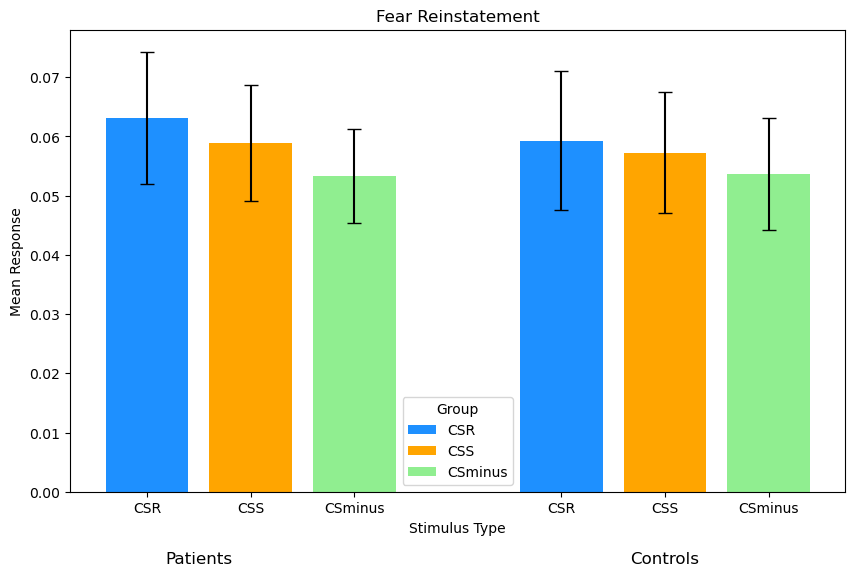

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['meanCSR3', 'meanCSS3', 'meanCSminus3'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR3': 'CSR', 
    'meanCSS3': 'CSS', 
    'meanCSminus3': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CSR'): 0, ('patient', 'CSS'): 1, ('patient', 'CSminus'): 2,
    ('control', 'CSR'): 4, ('control', 'CSS'): 5, ('control', 'CSminus'): 6
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CSR': 'dodgerblue',
    'CSS': 'orange',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(10, 6))

for group in ['patient', 'control']:
    for stim in ['CSR', 'CSS', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Add significance markers
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
        
        if result.pvalue < 0.05:  # Customize significance level if needed
            x1 = x_positions[(group1, stim1)]
            x2 = x_positions[(group2, stim2)]
            max_y = group_means['response'].max() + 0.025  # Adjust this if needed
            ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
            ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CSR'), ('patient', 'CSS')),   # Patient CSR vs CSS
    (('patient', 'CSR'), ('patient', 'CSminus')),  # Patient CSR vs CSminus
    (('patient', 'CSS'), ('patient', 'CSminus')),  # Patient CSS vs CSminus
    (('control', 'CSR'), ('control', 'CSS')),   # Control CSR vs CSS
    (('control', 'CSR'), ('control', 'CSminus')),  # Control CSR vs CSminus
    (('control', 'CSS'), ('control', 'CSminus')),  # Control CSS vs CSminus
    (('patient', 'CSR'), ('control', 'CSR')),    # Between-group CSR
    (('patient', 'CSS'), ('control', 'CSS')),    # Between-group CSS
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)
# Add x-axis labels to indicate groups
plt.text(0.5, -0.01, 'Patients', ha='center', va='top', fontsize=12)
plt.text(5, -0.01, 'Controls', ha='center', va='top', fontsize=12)

# Labeling and finalizing plot
plt.xticks([0, 1, 2, 4, 5, 6], ['CSR', 'CSS', 'CSminus', 'CSR', 'CSS', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response')
plt.title('Fear Reinstatement')
plt.legend(title='Group')
plt.show()


In [384]:
#### just placebo condition! 

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Filter to include only individuals in the placebo condition (drug_order = 0)
merged_data = merged_data[merged_data['drug_condition'] == 0]

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group',  'gender'], 
                    value_vars=['meanCSR3', 'meanCSS3', 'meanCSminus3'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR3': 1, 
    'meanCSS3': 2, 
    'meanCSminus3': 3
})

# Specify the model without intercept
model_formula = 'response ~ patient_group * stim_type'  # Removed 'drug' from model since all are placebo

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.2764
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.842
Time:                        08:24:13   Log-Likelihood:                 169.03
No. Observations:                 150   AIC:                            -330.1
Df Residuals:                     146   BIC:                            -318.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60532/1561891784.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60532/2228610193.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='patient_group', y='CSR_CSS', errorbar='se', palette=['red', 'blue'],alpha = 0.75)


Patient group CSR-CSS vs 0: t = 2.15, p = 0.043
Control group CSR-CSS vs 0: t = 1.68, p = 0.104
Between-group CSR-CSS comparison: t = 1.36, p = 0.186


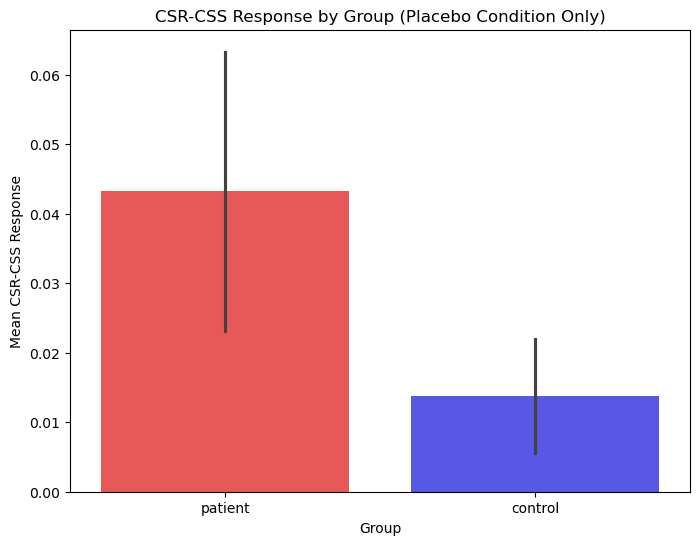

In [471]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Filter to include only individuals in the placebo condition (drug_order = 0)
merged_data = merged_data[merged_data['drug_condition'] == 0]

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate CSR-CSS difference
merged_data['CSR_CSS'] = merged_data['meanCSR3'] - merged_data['meanCSS3']

# Extract data for plotting
plot_data = merged_data[['subID', 'patient_group', 'CSR_CSS']]

# Plot the CSR-CSS response by group
plt.figure(figsize=(8, 6))
sns.barplot(data=plot_data, x='patient_group', y='CSR_CSS', errorbar='se', palette=['red', 'blue'],alpha = 0.75)

# Add labels
plt.xlabel('Group')
plt.ylabel('Mean CSR-CSS Response')
plt.title('CSR-CSS Response by Group (Placebo Condition Only)')

# Perform post-hoc t-tests
# Test if CSR-CSS is different from 0 within each group
patient_data = plot_data[plot_data['patient_group'] == 'patient']['CSR_CSS']
control_data = plot_data[plot_data['patient_group'] == 'control']['CSR_CSS']

# One-sample t-test within each group
patient_ttest = stats.ttest_1samp(patient_data, 0)
control_ttest = stats.ttest_1samp(control_data, 0)

print("Patient group CSR-CSS vs 0: t = {:.2f}, p = {:.3f}".format(patient_ttest.statistic, patient_ttest.pvalue))
print("Control group CSR-CSS vs 0: t = {:.2f}, p = {:.3f}".format(control_ttest.statistic, control_ttest.pvalue))

# Independent t-test between groups
between_groups_ttest = stats.ttest_ind(patient_data, control_data, equal_var=False)
print("Between-group CSR-CSS comparison: t = {:.2f}, p = {:.3f}".format(between_groups_ttest.statistic, between_groups_ttest.pvalue))

# Display plot
filename = 'early_trials_phase3_SCR_patientsvcontrols_placeboonly.png'
plt.savefig(filename, format='png', dpi=300)
plt.show()


### Phase 2 / 3 - early vs late (first half vs second half) 

In [473]:
import pandas as pd
import numpy as np

exclude_participants = 1

# Parameters to adjust:
trialnumber2_early = range(1, 13)  # Early trials for Phase 2 (1:12)
trialnumber2_late = range(13, 25)   # Late trials for Phase 2 (13:24)
trialnumber3_early = range(25, 37)  # Early trials for Phase 3 (25:36)
trialnumber3_late = range(37, 49)   # Late trials for Phase 3 (37:48)

excludeparticipants = 1  # Set to 0 to include all subjects; if set to 1, participants with rejected trials >= rejtrials_threshold are excluded
rejtrials_threshold = 24  # Threshold for trial rejection; adjust according to trial number

# Load data
peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv')
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Separate data by participant, phase, and stim type
grouped_data = peakstatstable.groupby('sid')
dat = []

for participant in participants:
    data = grouped_data.get_group(participant)
    participant_data = {'subID': participant}

    # Ensuring consistent data structure
    if data.shape[0] == 48:
        
        # Phase 2 processing: stims numbered in trialnumber2
        phase2_data = data[data['stNum'].isin(range(1, 25))]
        rejTrials = phase2_data[phase2_data['phaBase2Peak'] < 0.02].index
        phase2_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials2'] = len(rejTrials)

        # Separate out stim types for early trials
        phase2_early_data = phase2_data[phase2_data['stNum'].isin(trialnumber2_early)]
        data2_early = {key: value for key, value in phase2_early_data.groupby('stTy')}
        
        # Calculate means and SE for early trials
        try:
            participant_data['meanCSS2_early'] = data2_early['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2_early'] = data2_early['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS+S']))
            participant_data['nCSS2_early'] = len(data2_early['CS+S'])
            participant_data['meanCSR2_early'] = data2_early['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2_early'] = data2_early['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS+R']))
            participant_data['nCSR2_early'] = len(data2_early['CS+R'])
            participant_data['meanCSminus2_early'] = data2_early['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2_early'] = data2_early['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS-']))
            participant_data['nCSminus2_early'] = len(data2_early['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 2 early trials.")

        # Separate out stim types for late trials
        phase2_late_data = phase2_data[phase2_data['stNum'].isin(trialnumber2_late)]
        data2_late = {key: value for key, value in phase2_late_data.groupby('stTy')}
        
        # Calculate means and SE for late trials
        try:
            participant_data['meanCSS2_late'] = data2_late['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2_late'] = data2_late['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS+S']))
            participant_data['nCSS2_late'] = len(data2_late['CS+S'])
            participant_data['meanCSR2_late'] = data2_late['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2_late'] = data2_late['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS+R']))
            participant_data['nCSR2_late'] = len(data2_late['CS+R'])
            participant_data['meanCSminus2_late'] = data2_late['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2_late'] = data2_late['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS-']))
            participant_data['nCSminus2_late'] = len(data2_late['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 2 late trials.")

        # Phase 3 processing: stims numbered in trialnumber3
        phase3_data = data[data['stNum'].isin(range(25, 49))]
        rejTrials = phase3_data[phase3_data['phaBase2Peak'] < 0.02].index
        phase3_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials3'] = len(rejTrials)

        # Separate out stim types for early trials
        phase3_early_data = phase3_data[phase3_data['stNum'].isin(trialnumber3_early)]
        data3_early = {key: value for key, value in phase3_early_data.groupby('stTy')}
        
        # Calculate means and SE for early trials
        try:
            participant_data['meanCSS3_early'] = data3_early['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3_early'] = data3_early['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS+S']))
            participant_data['nCSS3_early'] = len(data3_early['CS+S'])
            participant_data['meanCSR3_early'] = data3_early['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3_early'] = data3_early['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS+R']))
            participant_data['nCSR3_early'] = len(data3_early['CS+R'])
            participant_data['meanCSminus3_early'] = data3_early['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3_early'] = data3_early['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS-']))
            participant_data['nCSminus3_early'] = len(data3_early['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3 early trials.")

        # Separate out stim types for late trials
        phase3_late_data = phase3_data[phase3_data['stNum'].isin(trialnumber3_late)]
        data3_late = {key: value for key, value in phase3_late_data.groupby('stTy')}
        
        # Calculate means and SE for late trials
        try:
            participant_data['meanCSS3_late'] = data3_late['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3_late'] = data3_late['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS+S']))
            participant_data['nCSS3_late'] = len(data3_late['CS+S'])
            participant_data['meanCSR3_late'] = data3_late['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3_late'] = data3_late['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS+R']))
            participant_data['nCSR3_late'] = len(data3_late['CS+R'])
            participant_data['meanCSminus3_late'] = data3_late['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3_late'] = data3_late['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS-']))
            participant_data['nCSminus3_late'] = len(data3_late['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3 late trials.")

    # Add participant data to the main list
    dat.append(participant_data)


# Convert dat list to a DataFrame for easier viewing and export
dat_df = pd.DataFrame(dat)

if exclude_participants == 1:
    dat_df = dat_df[dat_df['rejTrials2'] < 24]

print(dat_df)


    subID  rejTrials2  meanCSS2_early  seCSS2_early  nCSS2_early  \
0    N101           3        0.017800      0.004499            5   
1    N103           4        0.035500      0.004093            4   
2    N104           4        0.014333      0.007172            3   
3    N105           5        0.025333      0.000882            3   
4    N106           0        0.025000      0.002000            3   
..    ...         ...             ...           ...          ...   
96   N255           0        0.031667      0.002404            3   
97   N257           3        0.024333      0.000333            3   
98   N258           0        0.030667      0.001453            3   
99   N259           0        0.030667      0.000333            3   
100  N260          11        0.027667      0.017477            3   

     meanCSR2_early  seCSR2_early  nCSR2_early  meanCSminus2_early  \
0          0.053333      0.025314            3            0.024000   
1          0.022000      0.022000          

#### Extinction 

In [474]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack early and late responses with a time variable
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR2_early', 'meanCSR2_late', 'meanCSS2_early', 'meanCSS2_late', 'meanCSminus2_early', 'meanCSminus2_late'], 
                    var_name='stim_type_time', 
                    value_name='response')

# Split 'stim_type_time' into separate 'stim_type' and 'time' columns
long_data['stim_type'] = long_data['stim_type_time'].str.extract(r'mean(\w+)_')[0]
long_data['time'] = long_data['stim_type_time'].str.extract(r'_(\w+)$')[0].map({'early': 1, 'late': 2})

# Map stim_type to numerical codes
long_data['stim_type'] = long_data['stim_type'].map({
    'CSR2': 1, 
    'CSS2': 2, 
    'CSminus2': 3
})

# Specify the model with time as a main effect
model_formula = 'response ~ patient_group * drug * stim_type + time + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.726
Date:                Mon, 11 Nov 2024   Prob (F-statistic):             0.0798
Time:                        09:02:39   Log-Likelihood:                 816.73
No. Observations:                 606   AIC:                            -1613.
Df Residuals:                     596   BIC:                            -1569.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [389]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# # Filter to include only individuals in the placebo condition (drug_order = 0)
# merged_data = merged_data[merged_data['drug'] == 0]


# Reshape data to stack early and late responses with a time variable
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR2_early', 'meanCSR2_late', 'meanCSS2_early', 'meanCSS2_late', 'meanCSminus2_early', 'meanCSminus2_late'], 
                    var_name='stim_type_time', 
                    value_name='response')

# Split 'stim_type_time' into separate 'stim_type' and 'time' columns
long_data['stim_type'] = long_data['stim_type_time'].str.extract(r'mean(\w+)_')[0]
long_data['time'] = long_data['stim_type_time'].str.extract(r'_(\w+)$')[0].map({'early': 1, 'late': 2})

# Map stim_type to numerical codes
long_data['stim_type'] = long_data['stim_type'].map({
    'CSR2': 1, 
    'CSS2': 2, 
    'CSminus2': 3
})

# Define the model formula without the patient_group term, as we are running separate models for each group
# model_formula = 'response ~ stim_type + drug + time + gender'
model_formula = 'response ~ stim_type * drug + time + gender'

# Run regression for patients (patient_group = 1)
patient_data = long_data[long_data['patient_group'] == 1]
patient_model = smf.ols(formula=model_formula, data=patient_data).fit()
print("Patient Group Regression Results:")
print(patient_model.summary())

# Run regression for controls (patient_group = 0)
control_data = long_data[long_data['patient_group'] == 0]
control_model = smf.ols(formula=model_formula, data=control_data).fit()
print("\nControl Group Regression Results:")
print(control_model.summary())


Patient Group Regression Results:
                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.387
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.229
Time:                        10:48:32   Log-Likelihood:                 393.02
No. Observations:                 294   AIC:                            -774.0
Df Residuals:                     288   BIC:                            -751.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept 

In [391]:
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx",'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store means and SEs
all_stats = {}

# Calculate means and SEs for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Early stage statistics for CSS2
    mean_early = group_data['meanCSS2_early'].mean()
    se_early = group_data['meanCSS2_early'].sem()
    all_stats[f'CSS_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSS2
    mean_late = group_data['meanCSS2_late'].mean()
    se_late = group_data['meanCSS2_late'].sem()
    all_stats[f'CSS_{group}_late'] = (mean_late, se_late)

    # Early stage statistics for CSR2
    mean_early = group_data['meanCSR2_early'].mean()
    se_early = group_data['meanCSR2_early'].sem()
    all_stats[f'CSR_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSR2
    mean_late = group_data['meanCSR2_late'].mean()
    se_late = group_data['meanCSR2_late'].sem()
    all_stats[f'CSR_{group}_late'] = (mean_late, se_late)

    # Early stage statistics for CSR2
    mean_early = group_data['meanCSminus2_early'].mean()
    se_early = group_data['meanCSminus2_early'].sem()
    all_stats[f'CSminus_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSR2
    mean_late = group_data['meanCSminus2_late'].mean()
    se_late = group_data['meanCSminus2_late'].sem()
    all_stats[f'CSminus_{group}_late'] = (mean_late, se_late)

import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx", 'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store all data
all_data = {}

# Populate all_data with raw data for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Store early and late stage data for each stimulus type
    all_data[f'CSS_{group}_early'] = group_data['meanCSS2_early'].values
    all_data[f'CSS_{group}_late'] = group_data['meanCSS2_late'].values
    all_data[f'CSR_{group}_early'] = group_data['meanCSR2_early'].values
    all_data[f'CSR_{group}_late'] = group_data['meanCSR2_late'].values
    all_data[f'CSminus_{group}_early'] = group_data['meanCSminus2_early'].values
    all_data[f'CSminus_{group}_late'] = group_data['meanCSminus2_late'].values



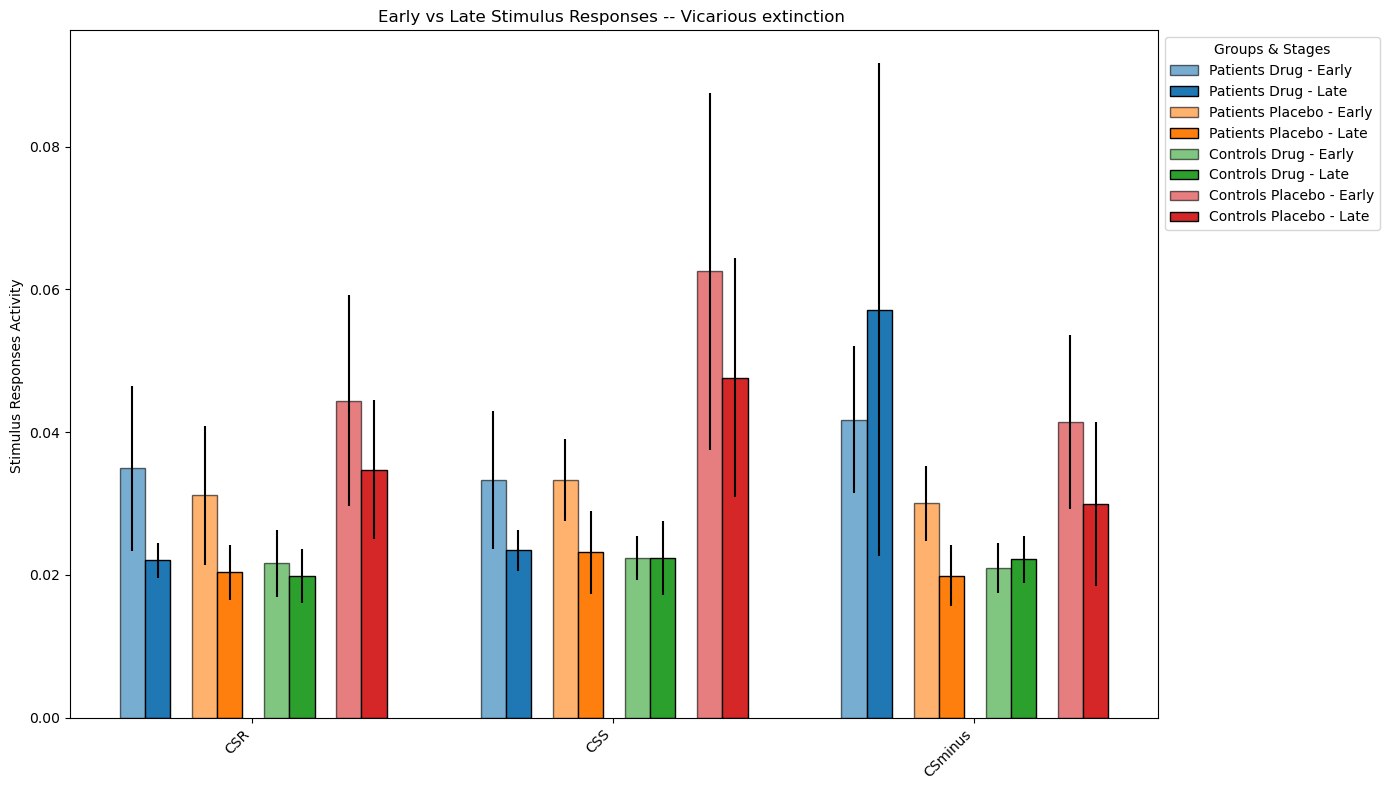

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_drug Early vs Late (CSR),1.069771,0.294554
1,patients_placebo Early vs Late (CSR),1.374439,0.183797
2,controls_drug Early vs Late (CSR),0.423700,0.675721
3,controls_placebo Early vs Late (CSR),1.285625,0.209492
4,Patients Drug vs Placebo (CSR Early),0.241878,0.809927
5,Control Drug vs Placebo (CSR Early),-1.373479,0.175731
6,Patients vs Controls Drug (CSR Early),1.022938,0.311361
7,Patients vs Controls Placebo (CSR Early),-0.704310,0.484643
8,Patients Drug vs Placebo (CSR Late),0.381760,0.704360
9,Control Drug vs Placebo (CSR Late),-1.339884,0.186341


In [392]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            for stage in ['early', 'late']:
                mean, se = all_stats[f'{stimulus}_{group}_{stage}']
                data.append({
                    'Stimulus': stimulus,
                    'Group': group.replace('_', ' ').title(),
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests using raw data in all_data
def calculate_posthoc_tests(all_data):
    results = []
    
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            early_values = all_data[f'{stimulus}_{group}_early']
            late_values = all_data[f'{stimulus}_{group}_late']
            t_stat, p_value = ttest_rel(early_values, late_values) if len(early_values) > 1 and len(late_values) > 1 else (np.nan, np.nan)
            results.append({'Comparison': f'{group} Early vs Late ({stimulus})', 'T-Stat': t_stat, 'P-Value': p_value})
        
        for stage in ['early', 'late']:
            patient_drug = all_data[f'{stimulus}_patients_drug_{stage}']
            patient_placebo = all_data[f'{stimulus}_patients_placebo_{stage}']
            control_drug = all_data[f'{stimulus}_controls_drug_{stage}']
            control_placebo = all_data[f'{stimulus}_controls_placebo_{stage}']

            for group_pair, (data1, data2) in {
                'Patients Drug vs Placebo': (patient_drug, patient_placebo),
                'Control Drug vs Placebo': (control_drug, control_placebo),
                'Patients vs Controls Drug': (patient_drug, control_drug),
                'Patients vs Controls Placebo': (patient_placebo, control_placebo)
            }.items():
                t_stat, p_value = ttest_ind(data1, data2) if len(data1) > 1 and len(data2) > 1 else (np.nan, np.nan)
                results.append({'Comparison': f'{group_pair} ({stimulus} {stage.capitalize()})', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to plot a multibar plot with error bars and significant annotations
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    
    plt.figure(figsize=(14, 8))
    stimuli = df['Stimulus'].unique()
    groups = df['Group'].unique()
    width = 0.35  # Width of each bar
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group

    # Plotting for each stimulus category
    for i, stimulus in enumerate(stimuli):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)  # Set x position for each stimulus group
        
        for j, group in enumerate(groups):
            group_data_early = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Early')]
            group_data_late = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Late')]
            
            # Plot bars with error bars
            plt.bar(x_pos[j] - width/2, group_data_early['Mean'].values[0], yerr=group_data_early['SE'].values[0],
                    width=width, color=colors[j], alpha=0.6, edgecolor='black', label=f'{group} - Early' if i == 0 else "")
            plt.bar(x_pos[j] + width/2, group_data_late['Mean'].values[0], yerr=group_data_late['SE'].values[0],
                    width=width, color=colors[j], alpha=1, edgecolor='black', label=f'{group} - Late' if i == 0 else "")

            # Annotate significant differences
            comparison_early_late = f'{group.replace(" ", "_").lower()}_early_vs_late_{stimulus.lower()}'
            if not stats_df[stats_df['Comparison'] == comparison_early_late].empty:
                p_value = stats_df[stats_df['Comparison'] == comparison_early_late]['P-Value'].values[0]
                if p_value < 0.05:
                    y = max(group_data_early['Mean'].values[0] + group_data_early['SE'].values[0],
                            group_data_late['Mean'].values[0] + group_data_late['SE'].values[0]) + 0.1
                    plt.plot([x_pos[j] - width/2, x_pos[j] + width/2], [y, y], color='black')
                    plt.text(x_pos[j], y + 0.05, '*', ha='center', va='bottom', color='black')

    # Customize the plot
    tick_pos = [x + width * 4.25 for x in range(0, len(stimuli) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, stimuli, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity ')
    plt.title(f'Early vs Late {title} -- Vicarious extinction ')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.show()

    # Display statistical table below the plot
    print("Statistical Test Results:")
    display(stats_df)

# Plot combined multibar plot for all stimulus categories
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


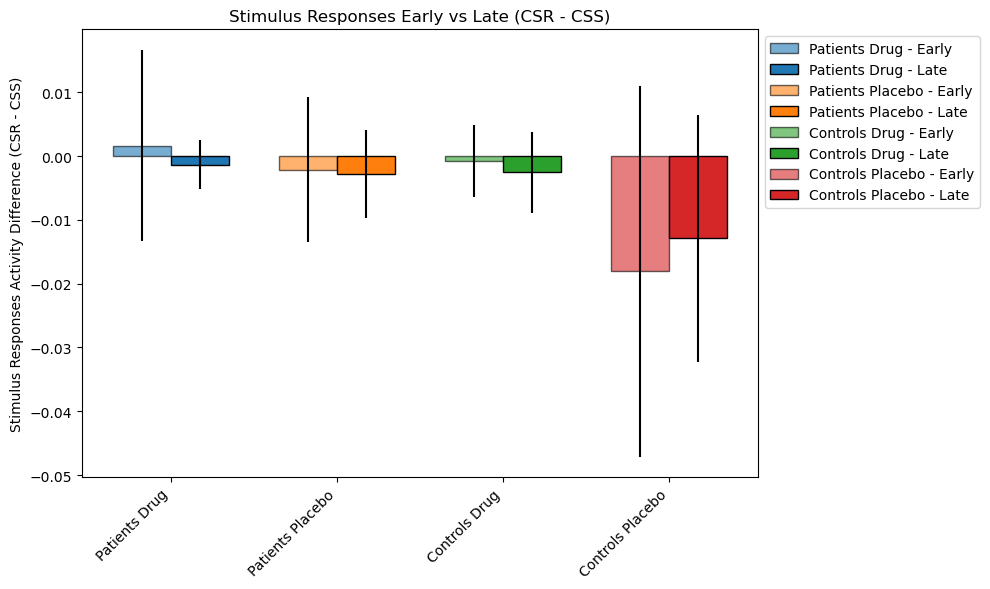

Within-Group Early vs Late Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_drug Early vs Late (CSR - CSS),0.342114,0.735015
1,patients_placebo Early vs Late (CSR - CSS),0.056192,0.955720
2,controls_drug Early vs Late (CSR - CSS),0.297451,0.768792
3,controls_placebo Early vs Late (CSR - CSS),-0.369764,0.714443



Drug vs Placebo Statistical Test Results:


,Comparison,T-Stat,P-Value
0,Patients Drug vs Placebo - Early (CSR - CSS),0.315099,0.754220
1,Controls Drug vs Placebo - Early (CSR - CSS),1.300234,0.202892
2,Patients Drug vs Placebo - Late (CSR - CSS),0.294497,0.769811
3,Controls Drug vs Placebo - Late (CSR - CSS),1.058388,0.295981


In [395]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data specifically for CSR - CSS comparisons
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
        for stage in ['early', 'late']:
            mean_csr, se_csr = all_stats[f'CSR_{group}_{stage}']
            mean_css, se_css = all_stats[f'CSS_{group}_{stage}']
            mean_diff = mean_csr - mean_css
            se_diff = np.sqrt(se_csr**2 + se_css**2)  # Assuming independence for SEs
            data.append({
                'Group': group.replace('_', ' ').title(),
                'Stage': 'Early' if stage == 'early' else 'Late',
                'Mean Difference (CSR - CSS)': mean_diff,
                'SE Difference': se_diff
            })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests for CSR - CSS differences
def calculate_posthoc_tests(all_data):
    results = []
    for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
        early_values_csr = all_data[f'CSR_{group}_early']
        early_values_css = all_data[f'CSS_{group}_early']
        late_values_csr = all_data[f'CSR_{group}_late']
        late_values_css = all_data[f'CSS_{group}_late']
        
        # Calculate CSR - CSS differences
        early_diff = np.array(early_values_csr) - np.array(early_values_css)
        late_diff = np.array(late_values_csr) - np.array(late_values_css)
        
        # Perform paired t-tests for early vs late within each group
        t_stat, p_value = ttest_rel(early_diff, late_diff) if len(early_diff) > 1 and len(late_diff) > 1 else (np.nan, np.nan)
        results.append({'Comparison': f'{group} Early vs Late (CSR - CSS)', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to perform post-hoc t-tests between drug and placebo within each group
def calculate_drug_placebo_tests(all_data):
    results = []
    for stage in ['early', 'late']:
        # Patients: Drug vs Placebo
        patients_drug = np.array(all_data[f'CSR_patients_drug_{stage}']) - np.array(all_data[f'CSS_patients_drug_{stage}'])
        patients_placebo = np.array(all_data[f'CSR_patients_placebo_{stage}']) - np.array(all_data[f'CSS_patients_placebo_{stage}'])
        t_stat, p_value = ttest_ind(patients_drug, patients_placebo, equal_var=False)
        results.append({'Comparison': f'Patients Drug vs Placebo - {stage.title()} (CSR - CSS)', 'T-Stat': t_stat, 'P-Value': p_value})
        
        # Controls: Drug vs Placebo
        controls_drug = np.array(all_data[f'CSR_controls_drug_{stage}']) - np.array(all_data[f'CSS_controls_drug_{stage}'])
        controls_placebo = np.array(all_data[f'CSR_controls_placebo_{stage}']) - np.array(all_data[f'CSS_controls_placebo_{stage}'])
        t_stat, p_value = ttest_ind(controls_drug, controls_placebo, equal_var=False)
        results.append({'Comparison': f'Controls Drug vs Placebo - {stage.title()} (CSR - CSS)', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to plot multibar plot for CSR - CSS differences with error bars
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    drug_placebo_df = calculate_drug_placebo_tests(all_data)  # Additional post-hoc tests for drug vs placebo
    
    plt.figure(figsize=(10, 6))
    groups = df['Group'].unique()
    width = 0.35
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    # Plotting CSR - CSS differences for each group and stage
    for j, group in enumerate(groups):
        group_data_early = df[(df['Group'] == group) & (df['Stage'] == 'Early')]
        group_data_late = df[(df['Group'] == group) & (df['Stage'] == 'Late')]
        
        # Plot bars with error bars
        plt.bar(j - width/2, group_data_early['Mean Difference (CSR - CSS)'].values[0],
                yerr=group_data_early['SE Difference'].values[0], width=width, color=colors[j], alpha=0.6,
                edgecolor='black', label=f'{group} - Early')
        plt.bar(j + width/2, group_data_late['Mean Difference (CSR - CSS)'].values[0],
                yerr=group_data_late['SE Difference'].values[0], width=width, color=colors[j], alpha=1,
                edgecolor='black', label=f'{group} - Late')
        
        # Annotate significant differences
        comparison = f'{group.replace(" ", "_").lower()}_early_vs_late'
        if not stats_df[stats_df['Comparison'] == comparison].empty:
            p_value = stats_df[stats_df['Comparison'] == comparison]['P-Value'].values[0]
            if p_value < 0.05:
                y = max(group_data_early['Mean Difference (CSR - CSS)'].values[0] + group_data_early['SE Difference'].values[0],
                        group_data_late['Mean Difference (CSR - CSS)'].values[0] + group_data_late['SE Difference'].values[0]) + 0.1
                plt.plot([j - width/2, j + width/2], [y, y], color='black')
                plt.text(j, y + 0.05, '*', ha='center', va='bottom', color='black')
    
    # Customize the plot 
    plt.xticks(range(len(groups)), groups, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity Difference (CSR - CSS)')
    plt.title(f'{title} Early vs Late (CSR - CSS)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()
    
    # Display statistical tables
    print("Within-Group Early vs Late Statistical Test Results:")
    display(stats_df)
    
    print("\nDrug vs Placebo Statistical Test Results:")
    display(drug_placebo_df)

# Run the plot for CSR - CSS differences
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


In [372]:
#### just placebo condition ! 
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx", 'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Filter to include only individuals in the placebo condition (drug_order = 0)
data = data[data['drug_condition'] == 0]


# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        # 'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        # 'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)


# Initialize dictionary to store means and SEs
all_stats = {}

# Calculate means and SEs for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Early stage statistics for CSS2
    mean_early = group_data['meanCSS2_early'].mean()
    se_early = group_data['meanCSS2_early'].sem()
    all_stats[f'CSS_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSS2
    mean_late = group_data['meanCSS2_late'].mean()
    se_late = group_data['meanCSS2_late'].sem()
    all_stats[f'CSS_{group}_late'] = (mean_late, se_late)

    # Early stage statistics for CSR2
    mean_early = group_data['meanCSR2_early'].mean()
    se_early = group_data['meanCSR2_early'].sem()
    all_stats[f'CSR_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSR2
    mean_late = group_data['meanCSR2_late'].mean()
    se_late = group_data['meanCSR2_late'].sem()
    all_stats[f'CSR_{group}_late'] = (mean_late, se_late)

    # Early stage statistics for CSR2
    mean_early = group_data['meanCSminus2_early'].mean()
    se_early = group_data['meanCSminus2_early'].sem()
    all_stats[f'CSminus_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSR2
    mean_late = group_data['meanCSminus2_late'].mean()
    se_late = group_data['meanCSminus2_late'].sem()
    all_stats[f'CSminus_{group}_late'] = (mean_late, se_late)

import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx", 'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Filter to include only individuals in the placebo condition (drug_order = 0)
data = data[data['drug_condition'] == 0]


# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        # 'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        # 'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store all data
all_data = {}

# Populate all_data with raw data for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Store early and late stage data for each stimulus type
    all_data[f'CSS_{group}_early'] = group_data['meanCSS2_early'].values
    all_data[f'CSS_{group}_late'] = group_data['meanCSS2_late'].values
    all_data[f'CSR_{group}_early'] = group_data['meanCSR2_early'].values
    all_data[f'CSR_{group}_late'] = group_data['meanCSR2_late'].values
    all_data[f'CSminus_{group}_early'] = group_data['meanCSminus2_early'].values
    all_data[f'CSminus_{group}_late'] = group_data['meanCSminus2_late'].values



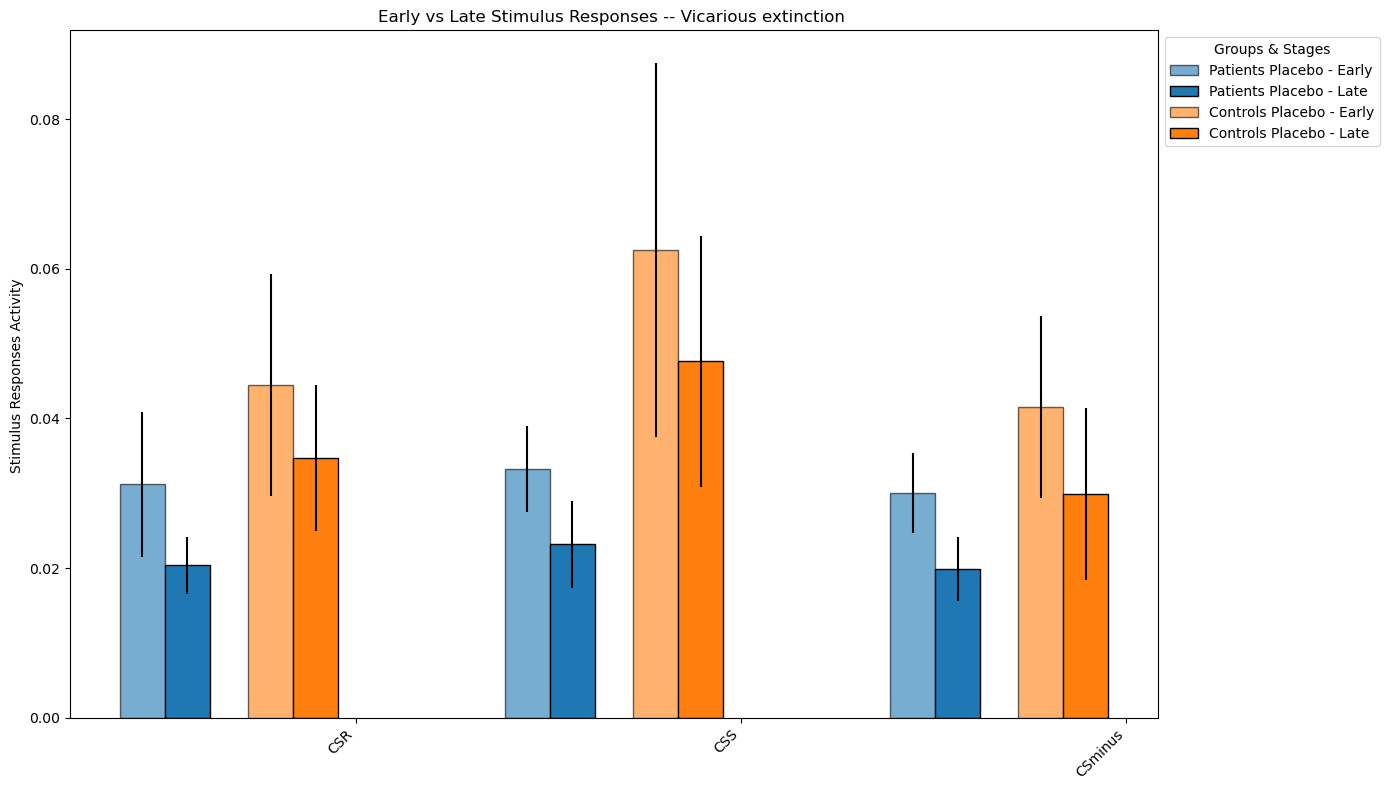

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_placebo Early vs Late (CSR),1.374439,0.183797
1,controls_placebo Early vs Late (CSR),1.285625,0.209492
2,Patients vs Controls Placebo (CSR Early),-0.704310,0.484643
3,Patients vs Controls Placebo (CSR Late),-1.244881,0.219219
4,patients_placebo Early vs Late (CSS),1.499589,0.148605
5,controls_placebo Early vs Late (CSS),0.891609,0.380480
6,Patients vs Controls Placebo (CSS Early),-1.018761,0.313424
7,Patients vs Controls Placebo (CSS Late),-1.247182,0.218382
8,patients_placebo Early vs Late (CSminus),2.058912,0.052120
9,controls_placebo Early vs Late (CSminus),2.232948,0.034038


In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_placebo','controls_placebo']:
            for stage in ['early', 'late']:
                mean, se = all_stats[f'{stimulus}_{group}_{stage}']
                data.append({
                    'Stimulus': stimulus,
                    'Group': group.replace('_', ' ').title(),
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests using raw data in all_data
def calculate_posthoc_tests(all_data):
    results = []
    
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_placebo','controls_placebo']:
            early_values = all_data[f'{stimulus}_{group}_early']
            late_values = all_data[f'{stimulus}_{group}_late']
            t_stat, p_value = ttest_rel(early_values, late_values) if len(early_values) > 1 and len(late_values) > 1 else (np.nan, np.nan)
            results.append({'Comparison': f'{group} Early vs Late ({stimulus})', 'T-Stat': t_stat, 'P-Value': p_value})
        
        for stage in ['early', 'late']:
            patient_placebo = all_data[f'{stimulus}_patients_placebo_{stage}']
            control_placebo = all_data[f'{stimulus}_controls_placebo_{stage}']

            for group_pair, (data1, data2) in {
                'Patients vs Controls Placebo': (patient_placebo, control_placebo)
            }.items():
                t_stat, p_value = ttest_ind(data1, data2) if len(data1) > 1 and len(data2) > 1 else (np.nan, np.nan)
                results.append({'Comparison': f'{group_pair} ({stimulus} {stage.capitalize()})', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to plot a multibar plot with error bars and significant annotations
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    
    plt.figure(figsize=(14, 8))
    stimuli = df['Stimulus'].unique()
    groups = df['Group'].unique()
    width = 0.35  # Width of each bar
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group

    # Plotting for each stimulus category
    for i, stimulus in enumerate(stimuli):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)  # Set x position for each stimulus group
        
        for j, group in enumerate(groups):
            group_data_early = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Early')]
            group_data_late = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Late')]
            
            # Plot bars with error bars
            plt.bar(x_pos[j] - width/2, group_data_early['Mean'].values[0], yerr=group_data_early['SE'].values[0],
                    width=width, color=colors[j], alpha=0.6, edgecolor='black', label=f'{group} - Early' if i == 0 else "")
            plt.bar(x_pos[j] + width/2, group_data_late['Mean'].values[0], yerr=group_data_late['SE'].values[0],
                    width=width, color=colors[j], alpha=1, edgecolor='black', label=f'{group} - Late' if i == 0 else "")

            # Annotate significant differences
            comparison_early_late = f'{group.replace(" ", "_").lower()}_early_vs_late_{stimulus.lower()}'
            if not stats_df[stats_df['Comparison'] == comparison_early_late].empty:
                p_value = stats_df[stats_df['Comparison'] == comparison_early_late]['P-Value'].values[0]
                if p_value < 0.05:
                    y = max(group_data_early['Mean'].values[0] + group_data_early['SE'].values[0],
                            group_data_late['Mean'].values[0] + group_data_late['SE'].values[0]) + 0.1
                    plt.plot([x_pos[j] - width/2, x_pos[j] + width/2], [y, y], color='black')
                    plt.text(x_pos[j], y + 0.05, '*', ha='center', va='bottom', color='black')

    # Customize the plot
    tick_pos = [x + width * 4.25 for x in range(0, len(stimuli) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, stimuli, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity ')
    plt.title(f'Early vs Late {title} -- Vicarious extinction ')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.show()

    # Display statistical table below the plot
    print("Statistical Test Results:")
    display(stats_df)

# Plot combined multibar plot for all stimulus categories
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


In [ ]:
for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_placebo','controls_placebo']:
            early_values = all_data[f'{stimulus}_{group}_early']
            late_values = all_data[f'{stimulus}_{group}_late']
            t_stat, p_value = ttest_rel(early_values, late_values) if len(early_values) > 1 and len(late_values) > 1 else (np.nan, np.nan)
            results.append({'Comparison': f'{group} Early vs Late ({stimulus})', 'T-Stat': t_stat, 'P-Value': p_value})
        

In [377]:
all_data['CSS_patients_placebo_early']

array([0.0178    , 0.00966667, 0.08666667, 0.008     , 0.        ,
       0.        , 0.05133333, 0.02066667, 0.02233333, 0.02733333,
       0.04266667, 0.041     , 0.        , 0.055     , 0.09233333,
       0.05033333, 0.022     , 0.06      , 0.        , 0.02466667,
       0.04433333, 0.056     ])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_placebo','controls_placebo']:
            for stage in ['early', 'late']:
                mean, se = all_stats[f'{stimulus}_{group}_{stage}']
                data.append({
                    'Stimulus': stimulus,
                    'Group': group.replace('_', ' ').title(),
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests using raw data in all_data
def calculate_posthoc_tests(all_data):
    results = []
    
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_placebo','controls_placebo']:
            early_values = all_data[f'{stimulus}_{group}_early']
            late_values = all_data[f'{stimulus}_{group}_late']
            t_stat, p_value = ttest_rel(early_values, late_values) if len(early_values) > 1 and len(late_values) > 1 else (np.nan, np.nan)
            results.append({'Comparison': f'{group} Early vs Late ({stimulus})', 'T-Stat': t_stat, 'P-Value': p_value})
        
        for stage in ['early', 'late']:
            patient_placebo = all_data[f'{stimulus}_patients_placebo_{stage}']
            control_placebo = all_data[f'{stimulus}_controls_placebo_{stage}']

            for group_pair, (data1, data2) in {
                'Patients vs Controls Placebo': (patient_placebo, control_placebo)
            }.items():
                t_stat, p_value = ttest_ind(data1, data2) if len(data1) > 1 and len(data2) > 1 else (np.nan, np.nan)
                results.append({'Comparison': f'{group_pair} ({stimulus} {stage.capitalize()})', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to plot a multibar plot with error bars and significant annotations
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    
    plt.figure(figsize=(14, 8))
    stimuli = df['Stimulus'].unique()
    groups = df['Group'].unique()
    width = 0.35  # Width of each bar
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group

    # Plotting for each stimulus category
    for i, stimulus in enumerate(stimuli):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)  # Set x position for each stimulus group
        
        for j, group in enumerate(groups):
            group_data_early = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Early')]
            group_data_late = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Late')]
            
            # Plot bars with error bars
            plt.bar(x_pos[j] - width/2, group_data_early['Mean'].values[0], yerr=group_data_early['SE'].values[0],
                    width=width, color=colors[j], alpha=0.6, edgecolor='black', label=f'{group} - Early' if i == 0 else "")
            plt.bar(x_pos[j] + width/2, group_data_late['Mean'].values[0], yerr=group_data_late['SE'].values[0],
                    width=width, color=colors[j], alpha=1, edgecolor='black', label=f'{group} - Late' if i == 0 else "")

            # Annotate significant differences
            comparison_early_late = f'{group.replace(" ", "_").lower()}_early_vs_late_{stimulus.lower()}'
            if not stats_df[stats_df['Comparison'] == comparison_early_late].empty:
                p_value = stats_df[stats_df['Comparison'] == comparison_early_late]['P-Value'].values[0]
                if p_value < 0.05:
                    y = max(group_data_early['Mean'].values[0] + group_data_early['SE'].values[0],
                            group_data_late['Mean'].values[0] + group_data_late['SE'].values[0]) + 0.1
                    plt.plot([x_pos[j] - width/2, x_pos[j] + width/2], [y, y], color='black')
                    plt.text(x_pos[j], y + 0.05, '*', ha='center', va='bottom', color='black')

    # Customize the plot
    tick_pos = [x + width * 4.25 for x in range(0, len(stimuli) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, stimuli, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity ')
    plt.title(f'Early vs Late {title} -- Vicarious extinction ')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.show()

    # Display statistical table below the plot
    print("Statistical Test Results:")
    display(stats_df)

# Plot combined multibar plot for all stimulus categories
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


#### Reinstatement

In [404]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack early and late responses with a time variable
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR3_early', 'meanCSR3_late', 'meanCSS3_early', 'meanCSS3_late', 'meanCSminus3_early', 'meanCSminus3_late'], 
                    var_name='stim_type_time', 
                    value_name='response')

# Split 'stim_type_time' into separate 'stim_type' and 'time' columns
long_data['stim_type'] = long_data['stim_type_time'].str.extract(r'mean(\w+)_')[0]
long_data['time'] = long_data['stim_type_time'].str.extract(r'_(\w+)$')[0].map({'early': 0, 'late': 1})

# Map stim_type to numerical codes
long_data['stim_type'] = long_data['stim_type'].map({
    'CSR3': 1, 
    'CSS3': 2, 
    'CSminus3': 3
})

# Specify the model with time as a main effect
model_formula = 'response ~ patient_group * drug * stim_type + time + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     5.948
Date:                Fri, 08 Nov 2024   Prob (F-statistic):           5.46e-08
Time:                        11:53:12   Log-Likelihood:                 628.45
No. Observations:                 606   AIC:                            -1237.
Df Residuals:                     596   BIC:                            -1193.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [403]:
### removing time

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack early and late responses with a time variable
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR3_early', 'meanCSR3_late', 'meanCSS3_early', 'meanCSS3_late', 'meanCSminus3_early', 'meanCSminus3_late'], 
                    var_name='stim_type_time', 
                    value_name='response')

# Split 'stim_type_time' into separate 'stim_type' and 'time' columns
long_data['stim_type'] = long_data['stim_type_time'].str.extract(r'mean(\w+)_')[0]
long_data['time'] = long_data['stim_type_time'].str.extract(r'_(\w+)$')[0].map({'early': 0, 'late': 1})

# Map stim_type to numerical codes
long_data['stim_type'] = long_data['stim_type'].map({
    'CSR3': 1, 
    'CSS3': 2, 
    'CSminus3': 3
})

# Filter data to include only early trials
early_data = long_data[long_data['time'] == 0]

# Specify the model without the 'time' term
model_formula = 'response ~ patient_group * drug * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=early_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.6716
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.716
Time:                        11:53:04   Log-Likelihood:                 249.66
No. Observations:                 303   AIC:                            -481.3
Df Residuals:                     294   BIC:                            -447.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [397]:
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx",'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store means and SEs
all_stats = {}

# Calculate means and SEs for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Early stage statistics for CSS2
    mean_early = group_data['meanCSS3_early'].mean()
    se_early = group_data['meanCSS3_early'].sem()
    all_stats[f'CSS_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSS2
    mean_late = group_data['meanCSS3_late'].mean()
    se_late = group_data['meanCSS3_late'].sem()
    all_stats[f'CSS_{group}_late'] = (mean_late, se_late)

    # Early stage statistics for CSR2
    mean_early = group_data['meanCSR3_early'].mean()
    se_early = group_data['meanCSR3_early'].sem()
    all_stats[f'CSR_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSR2
    mean_late = group_data['meanCSR3_late'].mean()
    se_late = group_data['meanCSR3_late'].sem()
    all_stats[f'CSR_{group}_late'] = (mean_late, se_late)

    # Early stage statistics for CSR2
    mean_early = group_data['meanCSminus3_early'].mean()
    se_early = group_data['meanCSminus3_early'].sem()
    all_stats[f'CSminus_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSR2
    mean_late = group_data['meanCSminus3_late'].mean()
    se_late = group_data['meanCSminus3_late'].sem()
    all_stats[f'CSminus_{group}_late'] = (mean_late, se_late)

import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx", 'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store all data
all_data = {}

# Populate all_data with raw data for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Store early and late stage data for each stimulus type
    all_data[f'CSS_{group}_early'] = group_data['meanCSS3_early'].values
    all_data[f'CSS_{group}_late'] = group_data['meanCSS3_late'].values
    all_data[f'CSR_{group}_early'] = group_data['meanCSR3_early'].values
    all_data[f'CSR_{group}_late'] = group_data['meanCSR3_late'].values
    all_data[f'CSminus_{group}_early'] = group_data['meanCSminus3_early'].values
    all_data[f'CSminus_{group}_late'] = group_data['meanCSminus3_late'].values



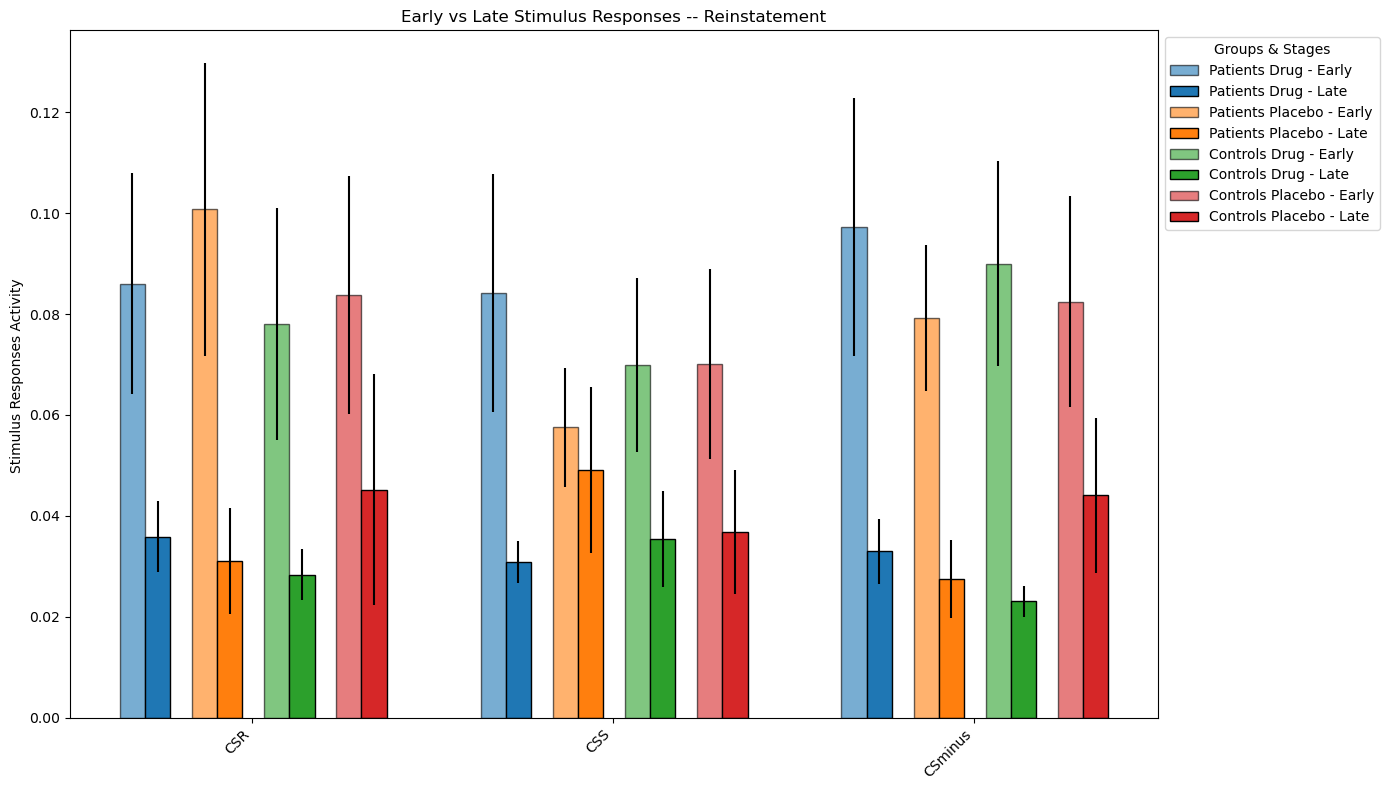

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_drug Early vs Late (CSR),2.982987,0.006133
1,patients_placebo Early vs Late (CSR),2.948044,0.007680
2,controls_drug Early vs Late (CSR),2.153339,0.042013
3,controls_placebo Early vs Late (CSR),1.512791,0.141951
4,Patients Drug vs Placebo (CSR Early),-0.412869,0.681580
5,Patients vs Controls Drug (CSR Early),0.252599,0.801635
6,Patients vs Controls Placebo (CSR Early),0.067871,0.946143
7,Patients Drug vs Placebo (CSR Late),0.394499,0.694997
8,Patients vs Controls Drug (CSR Late),0.850980,0.398920
9,Patients vs Controls Placebo (CSR Late),-0.381424,0.704414


In [398]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            for stage in ['early', 'late']:
                mean, se = all_stats[f'{stimulus}_{group}_{stage}']
                data.append({
                    'Stimulus': stimulus,
                    'Group': group.replace('_', ' ').title(),
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests using raw data in all_data
def calculate_posthoc_tests(all_data):
    results = []
    
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            early_values = all_data[f'{stimulus}_{group}_early']
            late_values = all_data[f'{stimulus}_{group}_late']
            t_stat, p_value = ttest_rel(early_values, late_values) if len(early_values) > 1 and len(late_values) > 1 else (np.nan, np.nan)
            results.append({'Comparison': f'{group} Early vs Late ({stimulus})', 'T-Stat': t_stat, 'P-Value': p_value})
        
        for stage in ['early', 'late']:
            patient_drug = all_data[f'{stimulus}_patients_drug_{stage}']
            patient_placebo = all_data[f'{stimulus}_patients_placebo_{stage}']
            control_drug = all_data[f'{stimulus}_controls_drug_{stage}']
            control_placebo = all_data[f'{stimulus}_controls_placebo_{stage}']

            for group_pair, (data1, data2) in {
                'Patients Drug vs Placebo': (patient_drug, patient_placebo),
                'Patients vs Controls Drug': (patient_drug, control_drug),
                'Patients vs Controls Placebo': (patient_drug, control_placebo)
            }.items():
                t_stat, p_value = ttest_ind(data1, data2) if len(data1) > 1 and len(data2) > 1 else (np.nan, np.nan)
                results.append({'Comparison': f'{group_pair} ({stimulus} {stage.capitalize()})', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to plot a multibar plot with error bars and significant annotations
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    
    plt.figure(figsize=(14, 8))
    stimuli = df['Stimulus'].unique()
    groups = df['Group'].unique()
    width = 0.35  # Width of each bar
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group

    # Plotting for each stimulus category
    for i, stimulus in enumerate(stimuli):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)  # Set x position for each stimulus group
        
        for j, group in enumerate(groups):
            group_data_early = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Early')]
            group_data_late = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Late')]
            
            # Plot bars with error bars
            plt.bar(x_pos[j] - width/2, group_data_early['Mean'].values[0], yerr=group_data_early['SE'].values[0],
                    width=width, color=colors[j], alpha=0.6, edgecolor='black', label=f'{group} - Early' if i == 0 else "")
            plt.bar(x_pos[j] + width/2, group_data_late['Mean'].values[0], yerr=group_data_late['SE'].values[0],
                    width=width, color=colors[j], alpha=1, edgecolor='black', label=f'{group} - Late' if i == 0 else "")

            # Annotate significant differences
            comparison_early_late = f'{group.replace(" ", "_").lower()}_early_vs_late_{stimulus.lower()}'
            if not stats_df[stats_df['Comparison'] == comparison_early_late].empty:
                p_value = stats_df[stats_df['Comparison'] == comparison_early_late]['P-Value'].values[0]
                if p_value < 0.05:
                    y = max(group_data_early['Mean'].values[0] + group_data_early['SE'].values[0],
                            group_data_late['Mean'].values[0] + group_data_late['SE'].values[0]) + 0.1
                    plt.plot([x_pos[j] - width/2, x_pos[j] + width/2], [y, y], color='black')
                    plt.text(x_pos[j], y + 0.05, '*', ha='center', va='bottom', color='black')

    # Customize the plot
    tick_pos = [x + width * 4.25 for x in range(0, len(stimuli) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, stimuli, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity ')
    plt.title(f'Early vs Late {title} -- Reinstatement')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.show()

    # Display statistical table below the plot
    print("Statistical Test Results:")
    display(stats_df)

# Plot combined multibar plot for all stimulus categories
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


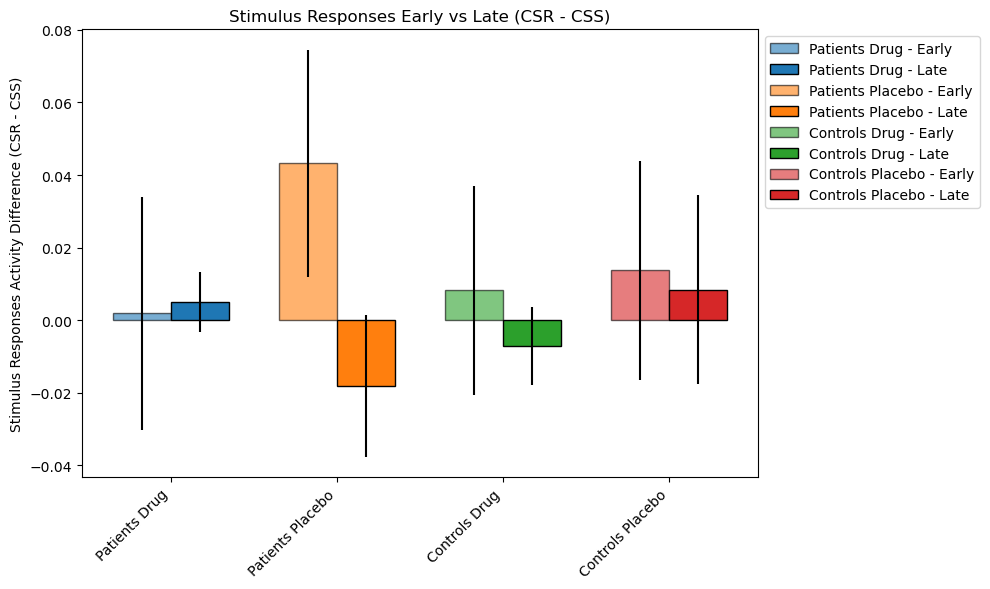

Within-Group Early vs Late Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_drug Early vs Late (CSR - CSS),-0.260878,0.796242
1,patients_placebo Early vs Late (CSR - CSS),2.054635,0.052568
2,controls_drug Early vs Late (CSR - CSS),0.875420,0.390396
3,controls_placebo Early vs Late (CSR - CSS),0.338243,0.737796



Drug vs Placebo Statistical Test Results:


,Comparison,T-Stat,P-Value
0,Patients Drug vs Placebo - Early (CSR - CSS),-1.805840,0.080107
1,Controls Drug vs Placebo - Early (CSR - CSS),-0.363329,0.718291
2,Patients Drug vs Placebo - Late (CSR - CSS),1.293368,0.206381
3,Controls Drug vs Placebo - Late (CSR - CSS),-1.040920,0.303054


In [399]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data specifically for CSR - CSS comparisons
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
        for stage in ['early', 'late']:
            mean_csr, se_csr = all_stats[f'CSR_{group}_{stage}']
            mean_css, se_css = all_stats[f'CSS_{group}_{stage}']
            mean_diff = mean_csr - mean_css
            se_diff = np.sqrt(se_csr**2 + se_css**2)  # Assuming independence for SEs
            data.append({
                'Group': group.replace('_', ' ').title(),
                'Stage': 'Early' if stage == 'early' else 'Late',
                'Mean Difference (CSR - CSS)': mean_diff,
                'SE Difference': se_diff
            })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests for CSR - CSS differences
def calculate_posthoc_tests(all_data):
    results = []
    for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
        early_values_csr = all_data[f'CSR_{group}_early']
        early_values_css = all_data[f'CSS_{group}_early']
        late_values_csr = all_data[f'CSR_{group}_late']
        late_values_css = all_data[f'CSS_{group}_late']
        
        # Calculate CSR - CSS differences
        early_diff = np.array(early_values_csr) - np.array(early_values_css)
        late_diff = np.array(late_values_csr) - np.array(late_values_css)
        
        # Perform paired t-tests for early vs late within each group
        t_stat, p_value = ttest_rel(early_diff, late_diff) if len(early_diff) > 1 and len(late_diff) > 1 else (np.nan, np.nan)
        results.append({'Comparison': f'{group} Early vs Late (CSR - CSS)', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to perform post-hoc t-tests between drug and placebo within each group
def calculate_drug_placebo_tests(all_data):
    results = []
    for stage in ['early', 'late']:
        # Patients: Drug vs Placebo
        patients_drug = np.array(all_data[f'CSR_patients_drug_{stage}']) - np.array(all_data[f'CSS_patients_drug_{stage}'])
        patients_placebo = np.array(all_data[f'CSR_patients_placebo_{stage}']) - np.array(all_data[f'CSS_patients_placebo_{stage}'])
        t_stat, p_value = ttest_ind(patients_drug, patients_placebo, equal_var=False)
        results.append({'Comparison': f'Patients Drug vs Placebo - {stage.title()} (CSR - CSS)', 'T-Stat': t_stat, 'P-Value': p_value})
        
        # Controls: Drug vs Placebo
        controls_drug = np.array(all_data[f'CSR_controls_drug_{stage}']) - np.array(all_data[f'CSS_controls_drug_{stage}'])
        controls_placebo = np.array(all_data[f'CSR_controls_placebo_{stage}']) - np.array(all_data[f'CSS_controls_placebo_{stage}'])
        t_stat, p_value = ttest_ind(controls_drug, controls_placebo, equal_var=False)
        results.append({'Comparison': f'Controls Drug vs Placebo - {stage.title()} (CSR - CSS)', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to plot multibar plot for CSR - CSS differences with error bars
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    drug_placebo_df = calculate_drug_placebo_tests(all_data)  # Additional post-hoc tests for drug vs placebo
    
    plt.figure(figsize=(10, 6))
    groups = df['Group'].unique()
    width = 0.35
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    # Plotting CSR - CSS differences for each group and stage
    for j, group in enumerate(groups):
        group_data_early = df[(df['Group'] == group) & (df['Stage'] == 'Early')]
        group_data_late = df[(df['Group'] == group) & (df['Stage'] == 'Late')]
        
        # Plot bars with error bars
        plt.bar(j - width/2, group_data_early['Mean Difference (CSR - CSS)'].values[0],
                yerr=group_data_early['SE Difference'].values[0], width=width, color=colors[j], alpha=0.6,
                edgecolor='black', label=f'{group} - Early')
        plt.bar(j + width/2, group_data_late['Mean Difference (CSR - CSS)'].values[0],
                yerr=group_data_late['SE Difference'].values[0], width=width, color=colors[j], alpha=1,
                edgecolor='black', label=f'{group} - Late')
        
        # Annotate significant differences
        comparison = f'{group.replace(" ", "_").lower()}_early_vs_late'
        if not stats_df[stats_df['Comparison'] == comparison].empty:
            p_value = stats_df[stats_df['Comparison'] == comparison]['P-Value'].values[0]
            if p_value < 0.05:
                y = max(group_data_early['Mean Difference (CSR - CSS)'].values[0] + group_data_early['SE Difference'].values[0],
                        group_data_late['Mean Difference (CSR - CSS)'].values[0] + group_data_late['SE Difference'].values[0]) + 0.1
                plt.plot([j - width/2, j + width/2], [y, y], color='black')
                plt.text(j, y + 0.05, '*', ha='center', va='bottom', color='black')
    
    # Customize the plot 
    plt.xticks(range(len(groups)), groups, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity Difference (CSR - CSS)')
    plt.title(f'{title} Early vs Late (CSR - CSS)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()
    
    # Display statistical tables
    print("Within-Group Early vs Late Statistical Test Results:")
    display(stats_df)
    
    print("\nDrug vs Placebo Statistical Test Results:")
    display(drug_placebo_df)

# Run the plot for CSR - CSS differences
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


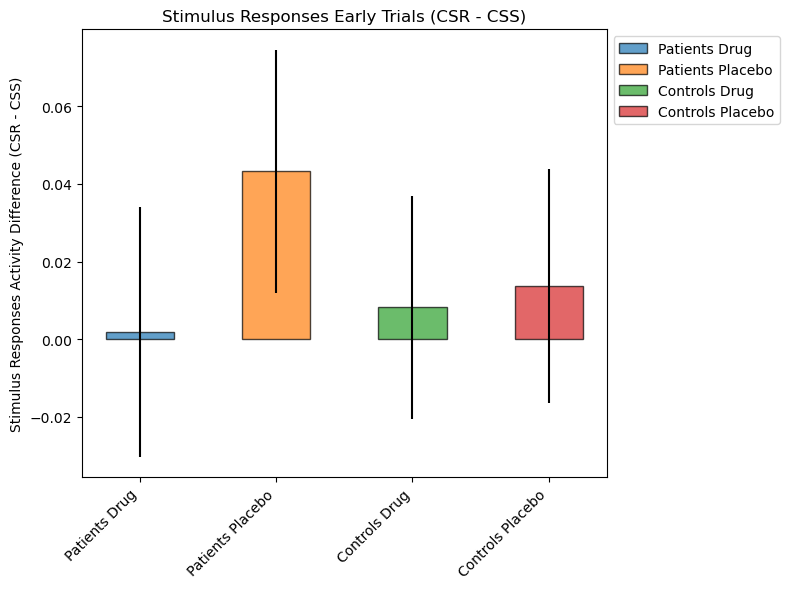

Within-Group Early Trial Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_drug CSR vs CSS (Early),0.175203,0.862277
1,patients_placebo CSR vs CSS (Early),2.149456,0.043408
2,controls_drug CSR vs CSS (Early),0.631972,0.533637
3,controls_placebo CSR vs CSS (Early),1.682054,0.104090
4,Patients Drug vs Placebo (Early),-1.805840,0.080107
5,Controls Drug vs Placebo (Early),-0.363329,0.718291


In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data specifically for CSR - CSS comparisons in early trials only
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
        # Only include early trials
        stage = 'early'
        mean_csr, se_csr = all_stats[f'CSR_{group}_{stage}']
        mean_css, se_css = all_stats[f'CSS_{group}_{stage}']
        mean_diff = mean_csr - mean_css
        se_diff = np.sqrt(se_csr**2 + se_css**2)  # Assuming independence for SEs
        data.append({
            'Group': group.replace('_', ' ').title(),
            'Stage': 'Early',
            'Mean Difference (CSR - CSS)': mean_diff,
            'SE Difference': se_diff
        })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests for CSR - CSS differences and drug vs. placebo in early trials
def calculate_posthoc_tests(all_data):
    results = []
    for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
        early_values_csr = all_data[f'CSR_{group}_early']
        early_values_css = all_data[f'CSS_{group}_early']
        
        # Calculate CSR - CSS differences for early trials
        early_diff = np.array(early_values_csr) - np.array(early_values_css)
        
        # Paired t-test between CSR and CSS for early trials
        t_stat, p_value = ttest_rel(early_values_csr, early_values_css) if len(early_values_csr) > 1 else (np.nan, np.nan)
        results.append({'Comparison': f'{group} CSR vs CSS (Early)', 'T-Stat': t_stat, 'P-Value': p_value})
    
    # Drug vs. Placebo comparisons for each group
    patients_drug = np.array(all_data['CSR_patients_drug_early']) - np.array(all_data['CSS_patients_drug_early'])
    patients_placebo = np.array(all_data['CSR_patients_placebo_early']) - np.array(all_data['CSS_patients_placebo_early'])
    controls_drug = np.array(all_data['CSR_controls_drug_early']) - np.array(all_data['CSS_controls_drug_early'])
    controls_placebo = np.array(all_data['CSR_controls_placebo_early']) - np.array(all_data['CSS_controls_placebo_early'])
    
    # Independent t-tests for drug vs placebo
    t_stat, p_value = ttest_ind(patients_drug, patients_placebo, equal_var=False)
    results.append({'Comparison': 'Patients Drug vs Placebo (Early)', 'T-Stat': t_stat, 'P-Value': p_value})
    
    t_stat, p_value = ttest_ind(controls_drug, controls_placebo, equal_var=False)
    results.append({'Comparison': 'Controls Drug vs Placebo (Early)', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to plot multibar plot for CSR - CSS differences in early trials only with error bars
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    
    plt.figure(figsize=(8, 6))
    groups = df['Group'].unique()
    width = 0.2  # Make bars narrower to fit closer together
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    # Plotting CSR - CSS differences for each group in early trials only
    for j, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot bar with error bars for early trials
        plt.bar(j * width * 2, group_data['Mean Difference (CSR - CSS)'].values[0],
                yerr=group_data['SE Difference'].values[0], width=width, color=colors[j], alpha=0.7,
                edgecolor='black', label=group)
        
        # Annotate significant differences within group (CSR vs CSS)
        comparison = f'{group.replace(" ", "_").lower()}_csr_vs_css_early'
        if not stats_df[stats_df['Comparison'] == f'{group} CSR vs CSS (Early)'].empty:
            p_value = stats_df[stats_df['Comparison'] == f'{group} CSR vs CSS (Early)']['P-Value'].values[0]
            if p_value < 0.05:
                y = group_data['Mean Difference (CSR - CSS)'].values[0] + group_data['SE Difference'].values[0] + 0.1
                plt.text(j * width * 2, y, '*', ha='center', va='bottom', color='black')
    
    # Customize the plot
    plt.xticks([i * width * 2 for i in range(len(groups))], groups, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity Difference (CSR - CSS)')
    plt.title(f'{title} Early Trials (CSR - CSS)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()
    
    # Display statistical test results
    print("Within-Group Early Trial Statistical Test Results:")
    display(stats_df)

# Run the plot for CSR - CSS differences in early trials only
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


## Peak-base, z-scored SCR value

z-scoring on an individual level basis -- trial peak-base - mean(all 24 trials) / mean(all trial trials)  -- doesn't look correct 


### Phase 1

In [184]:
import os
import pandas as pd
import numpy as np

# Set the working directory
path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

# Parameters
trialnumber = range(1, 25)  # Adjust to the first half of trials if needed
excludeparticipants = 1  # Set to 0 to include all participants
rejtrials_threshold = 24  # Adjust the threshold as needed

# Load the table
peakstatstable = pd.read_csv('peak_stats_table-phase1.csv')

# Extract unique participant IDs and trial types
participants = peakstatstable['sid'].unique()

# Add a group column based on participant IDs if needed
# This step assumes that participant IDs indicate their group. Adjust as necessary.
peakstatstable['group'] = np.where(peakstatstable['sid'].str.startswith('N1'), 'patient', 'control')  # Modify as needed

# Group data by participant
participant_groups = peakstatstable.groupby('sid')
dat = []

for participant_id in participants:
    data = participant_groups.get_group(participant_id)
    subject_data = {'subID': participant_id}

    # Process data if there are 24 trials
    if len(data) == 24:
        phase1_data = data[data['stNum'].isin(trialnumber)]

        # Rejected trials (based on "Publication recommendations for electrodermal measurements")
        rejTrials = phase1_data[phase1_data['phaBase2Peak'] < 0].index
        phase1_data.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0

        subject_data['rejTrials1'] = len(rejTrials)

        # Calculate participant-wise average and standard deviation
        participant_mean = phase1_data['phaBase2Peak'].mean()
        participant_std = phase1_data['phaBase2Peak'].std()

        # Separate data by stim type
        stim_groups = phase1_data.groupby('stTy')

        try:
            # Z-score the phaBase2Peak values for each stimulus type
            for stim_type, stim_data in stim_groups:
                # Calculate z-scores based on participant's mean and std
                z_scores = (stim_data['phaBase2Peak'] - participant_mean) / participant_std
                
                # Store the mean and SE of z-scores with the new variable names
                if stim_type == 'CS+S':
                    subject_data['meanCSS1'] = z_scores.mean()
                    subject_data['seCSS1'] = z_scores.std() / np.sqrt(len(z_scores))
                    subject_data['nCSS1'] = len(z_scores)
                elif stim_type == 'CS+R':
                    subject_data['meanCSR1'] = z_scores.mean()
                    subject_data['seCSR1'] = z_scores.std() / np.sqrt(len(z_scores))
                    subject_data['nCSR1'] = len(z_scores)
                elif stim_type == 'CS-':
                    subject_data['meanCSminus1'] = z_scores.mean()
                    subject_data['seCSminus1'] = z_scores.std() / np.sqrt(len(z_scores))
                    subject_data['nCSminus1'] = len(z_scores)

        except KeyError:
            print(f"Missing stim type data for participant {participant_id}")

    dat.append(subject_data)

# Convert to a DataFrame if you need a structured output
dat_df = pd.DataFrame(dat)

print(dat_df)


    subID  rejTrials1  meanCSR1    seCSR1  nCSR1  meanCSS1    seCSS1  nCSS1  \
0    N101           4 -0.191597  0.201230      8  0.461885  0.549469      8   
1    N102           0 -0.488130  0.104743      8  0.488130  0.552979      8   
2    N103           1  0.086566  0.364331      8 -0.120133  0.294204      8   
3    N104           5 -0.321006  0.131551      8 -0.207710  0.213842      8   
4    N105           2 -0.392065  0.196368      8  0.208545  0.389419      8   
..    ...         ...       ...       ...    ...       ...       ...    ...   
99   N255           6 -0.337741  0.094990      8 -0.369404  0.086299      8   
100  N257           4  0.093319  0.490107      8 -0.118077  0.235745      8   
101  N258           0 -0.079173  0.421012      8  0.200262  0.390068      8   
102  N259           2  0.336829  0.523763      8 -0.007322  0.275650      8   
103  N260           1 -0.106682  0.246396      8  0.109453  0.421726      8   

     meanCSminus1  seCSminus1  nCSminus1  
0   -2.7

#### CSR, CSS kept separate 

In [185]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 1, 
    'meanCSS1': 2, 
    'meanCSminus1': 3
})

# Specify the model without intercept
model_formula = 'response ~ patient_group * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.1637
Date:                Fri, 01 Nov 2024   Prob (F-statistic):              0.957
Time:                        12:42:04   Log-Likelihood:                -45.897
No. Observations:                 312   AIC:                             101.8
Df Residuals:                     307   BIC:                             120.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60532/4197659941.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


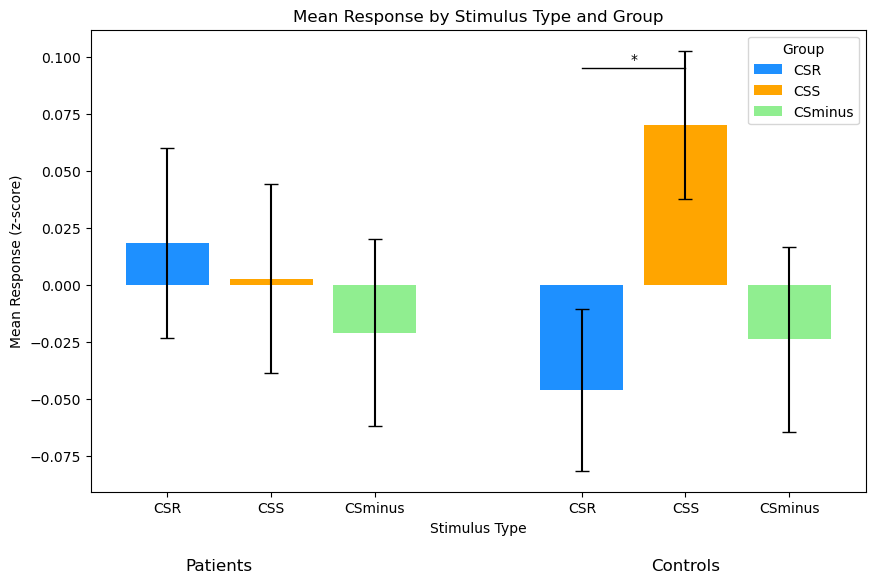

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 'CSR', 
    'meanCSS1': 'CSS', 
    'meanCSminus1': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CSR'): 0, ('patient', 'CSS'): 1, ('patient', 'CSminus'): 2,
    ('control', 'CSR'): 4, ('control', 'CSS'): 5, ('control', 'CSminus'): 6
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CSR': 'dodgerblue',
    'CSS': 'orange',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(10, 6))

for group in ['patient', 'control']:
    for stim in ['CSR', 'CSS', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Add significance markers
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
        
        if result.pvalue < 0.05:  # Customize significance level if needed
            x1 = x_positions[(group1, stim1)]
            x2 = x_positions[(group2, stim2)]
            max_y = group_means['response'].max() + 0.025  # Adjust this if needed
            ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
            ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CSR'), ('patient', 'CSS')),   # Patient CSR vs CSS
    (('patient', 'CSR'), ('patient', 'CSminus')),  # Patient CSR vs CSminus
    (('patient', 'CSS'), ('patient', 'CSminus')),  # Patient CSS vs CSminus
    (('control', 'CSR'), ('control', 'CSS')),   # Control CSR vs CSS
    (('control', 'CSR'), ('control', 'CSminus')),  # Control CSR vs CSminus
    (('control', 'CSS'), ('control', 'CSminus')),  # Control CSS vs CSminus
    (('patient', 'CSR'), ('control', 'CSR')),    # Between-group CSR
    (('patient', 'CSS'), ('control', 'CSS')),    # Between-group CSS
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)
# Add x-axis labels to indicate groups
plt.text(0.5, -0.12, 'Patients', ha='center', va='top', fontsize=12)
plt.text(5, -0.12, 'Controls', ha='center', va='top', fontsize=12)

# Labeling and finalizing plot
plt.xticks([0, 1, 2, 4, 5, 6], ['CSR', 'CSS', 'CSminus', 'CSR', 'CSS', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response (z-score)')
plt.title('Mean Response by Stimulus Type and Group')
plt.legend(title='Group')
plt.show()


#### CS+ vs CS- 

In [192]:
## treating CSR and CSS as the same categorical condition 

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)  # 1 for patient, 0 for control
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Combine CSR and CSS into a single variable called CS+
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 'CS+',  # Combine CSR
    'meanCSS1': 'CS+',  # Combine CSS
    'meanCSminus1': 'CSminus'  # Keep CSminus as is
})

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].astype('category')

# Specify the model without intercept
model_formula = 'response ~ patient_group * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.2494
Date:                Fri, 01 Nov 2024   Prob (F-statistic):              0.910
Time:                        12:44:31   Log-Likelihood:                -45.723
No. Observations:                 312   AIC:                             101.4
Df Residuals:                     307   BIC:                             120.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

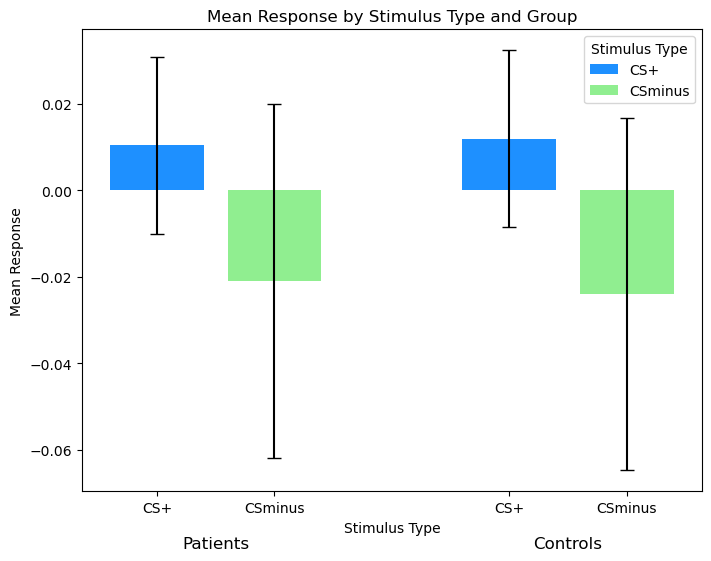

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate the mean of CSR and CSS for each subject to create CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Reshape data to stack CS_plus and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['CS_plus', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'CS_plus': 'CS+', 
    'meanCSminus1': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CS+'): 0, ('patient', 'CSminus'): 1,
    ('control', 'CS+'): 3, ('control', 'CSminus'): 4
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CS+': 'dodgerblue',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(8, 6))

for group in ['patient', 'control']:
    for stim in ['CS+', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Add significance markers
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
        
        if result.pvalue < 0.05:  # Customize significance level if needed
            x1 = x_positions[(group1, stim1)]
            x2 = x_positions[(group2, stim2)]
            max_y = group_means['response'].max() + 0.025  # Adjust this if needed
            ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
            ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CS+'), ('patient', 'CSminus')),   # Patient CS+ vs CSminus
    (('control', 'CS+'), ('control', 'CSminus')),   # Control CS+ vs CSminus
    (('patient', 'CS+'), ('control', 'CS+')),       # Between-group CS+
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)

# Labeling and finalizing plot
plt.xticks([0, 1, 3, 4], ['CS+', 'CSminus', 'CS+', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response')
plt.title('Mean Response by Stimulus Type and Group')

# Add x-axis labels to indicate groups
plt.text(0.5, -0.08, 'Patients', ha='center', va='top', fontsize=12)
plt.text(3.5, -0.08, 'Controls', ha='center', va='top', fontsize=12)

plt.legend(title='Stimulus Type')
plt.show()


## Rmeoving First CS- 

### Phase 1? 

### Phase 2/3 

In [411]:
import pandas as pd
import numpy as np

# Parameters to adjust:
trialnumber2_early = range(2, 13)  # Early trials for Phase 2 (2:12) - removed first CS- trial
trialnumber2_late = range(13, 25)   # Late trials for Phase 2 (13:24)
trialnumber3_early = range(26, 37)  # Early trials for Phase 3 (25:36) - removed first CS- trial
trialnumber3_late = range(37, 49)   # Late trials for Phase 3 (37:48)

excludeparticipants = 1  # Set to 0 to include all subjects; if set to 1, participants with rejected trials >= rejtrials_threshold are excluded
rejtrials_threshold = 24  # Threshold for trial rejection; adjust according to trial number

# Load data
peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv')
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Separate data by participant, phase, and stim type
grouped_data = peakstatstable.groupby('sid')
dat = []

for participant in participants:
    data = grouped_data.get_group(participant)
    participant_data = {'subID': participant}

    # Ensuring consistent data structure
    if data.shape[0] == 48:
        
        # Phase 2 processing: stims numbered in trialnumber2
        phase2_data = data[data['stNum'].isin(range(1, 25))]
        rejTrials = phase2_data[phase2_data['phaBase2Peak'] < 0.02].index
        phase2_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials2'] = len(rejTrials)

        # Separate out stim types for early trials
        phase2_early_data = phase2_data[phase2_data['stNum'].isin(trialnumber2_early)]
        data2_early = {key: value for key, value in phase2_early_data.groupby('stTy')}
        
        # Calculate means and SE for early trials
        try:
            participant_data['meanCSS2_early'] = data2_early['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2_early'] = data2_early['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS+S']))
            participant_data['nCSS2_early'] = len(data2_early['CS+S'])
            participant_data['meanCSR2_early'] = data2_early['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2_early'] = data2_early['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS+R']))
            participant_data['nCSR2_early'] = len(data2_early['CS+R'])
            participant_data['meanCSminus2_early'] = data2_early['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2_early'] = data2_early['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS-']))
            participant_data['nCSminus2_early'] = len(data2_early['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 2 early trials.")

        # Separate out stim types for late trials
        phase2_late_data = phase2_data[phase2_data['stNum'].isin(trialnumber2_late)]
        data2_late = {key: value for key, value in phase2_late_data.groupby('stTy')}
        
        # Calculate means and SE for late trials
        try:
            participant_data['meanCSS2_late'] = data2_late['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2_late'] = data2_late['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS+S']))
            participant_data['nCSS2_late'] = len(data2_late['CS+S'])
            participant_data['meanCSR2_late'] = data2_late['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2_late'] = data2_late['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS+R']))
            participant_data['nCSR2_late'] = len(data2_late['CS+R'])
            participant_data['meanCSminus2_late'] = data2_late['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2_late'] = data2_late['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS-']))
            participant_data['nCSminus2_late'] = len(data2_late['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 2 late trials.")

        # Phase 3 processing: stims numbered in trialnumber3
        phase3_data = data[data['stNum'].isin(range(25, 49))]
        rejTrials = phase3_data[phase3_data['phaBase2Peak'] < 0.02].index
        phase3_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials3'] = len(rejTrials)

        # Separate out stim types for early trials
        phase3_early_data = phase3_data[phase3_data['stNum'].isin(trialnumber3_early)]
        data3_early = {key: value for key, value in phase3_early_data.groupby('stTy')}
        
        # Calculate means and SE for early trials
        try:
            participant_data['meanCSS3_early'] = data3_early['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3_early'] = data3_early['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS+S']))
            participant_data['nCSS3_early'] = len(data3_early['CS+S'])
            participant_data['meanCSR3_early'] = data3_early['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3_early'] = data3_early['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS+R']))
            participant_data['nCSR3_early'] = len(data3_early['CS+R'])
            participant_data['meanCSminus3_early'] = data3_early['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3_early'] = data3_early['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS-']))
            participant_data['nCSminus3_early'] = len(data3_early['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3 early trials.")

        # Separate out stim types for late trials
        phase3_late_data = phase3_data[phase3_data['stNum'].isin(trialnumber3_late)]
        data3_late = {key: value for key, value in phase3_late_data.groupby('stTy')}
        
        # Calculate means and SE for late trials
        try:
            participant_data['meanCSS3_late'] = data3_late['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3_late'] = data3_late['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS+S']))
            participant_data['nCSS3_late'] = len(data3_late['CS+S'])
            participant_data['meanCSR3_late'] = data3_late['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3_late'] = data3_late['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS+R']))
            participant_data['nCSR3_late'] = len(data3_late['CS+R'])
            participant_data['meanCSminus3_late'] = data3_late['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3_late'] = data3_late['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS-']))
            participant_data['nCSminus3_late'] = len(data3_late['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3 late trials.")

    # Add participant data to the main list
    dat.append(participant_data)


# Convert dat list to a DataFrame for easier viewing and export
dat_df = pd.DataFrame(dat)

if exclude_participants == 1:
    dat_df = dat_df[dat_df['rejTrials2'] < 24]

print(dat_df)


    subID  rejTrials2  meanCSS2_early  seCSS2_early  nCSS2_early  \
0    N101           3        0.017800      0.004499            5   
1    N103           4        0.035667      0.005783            3   
2    N104           4        0.014333      0.007172            3   
3    N105           5        0.025333      0.000882            3   
4    N106           0        0.025000      0.002000            3   
..    ...         ...             ...           ...          ...   
96   N255           0        0.031667      0.002404            3   
97   N257           3        0.024333      0.000333            3   
98   N258           0        0.030667      0.001453            3   
99   N259           0        0.030667      0.000333            3   
100  N260          11        0.027667      0.017477            3   

     meanCSR2_early  seCSR2_early  nCSR2_early  meanCSminus2_early  \
0          0.053333      0.025314            3            0.024333   
1          0.022000      0.022000          

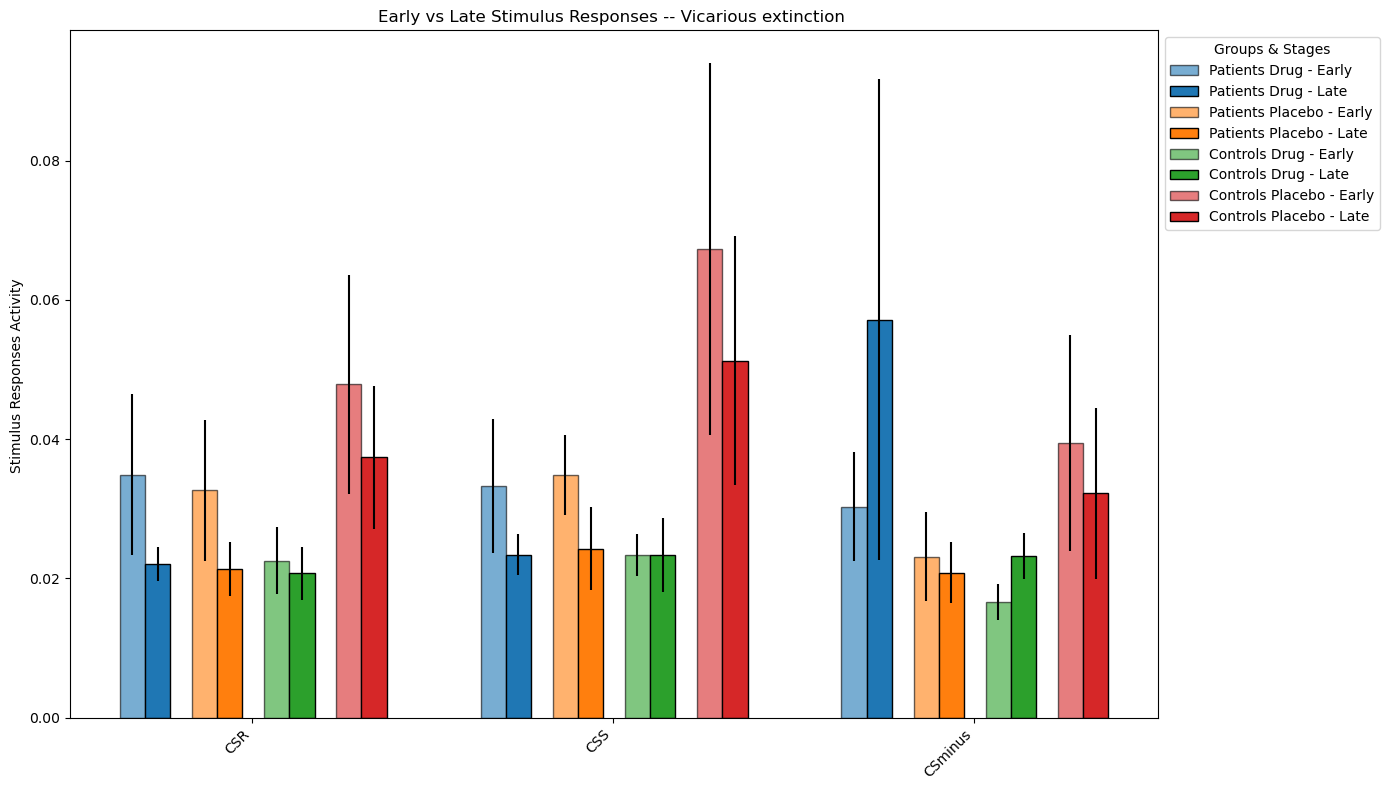

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_drug Early vs Late (CSR),1.069771,0.294554
1,patients_placebo Early vs Late (CSR),1.375830,0.184087
2,controls_drug Early vs Late (CSR),0.423371,0.676135
3,controls_placebo Early vs Late (CSR),1.286826,0.209943
4,Patients Drug vs Placebo (CSR Early),0.143176,0.886776
5,Control Drug vs Placebo (CSR Early),-1.454085,0.152569
6,Patients vs Controls Drug (CSR Early),0.932373,0.355810
7,Patients vs Controls Placebo (CSR Early),-0.768439,0.446240
8,Patients Drug vs Placebo (CSR Late),0.160721,0.873017
9,Control Drug vs Placebo (CSR Late),-1.443332,0.155560


## All 3 phases in 1 figure 

In [414]:
import os

path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

import pandas as pd
import numpy as np

# Parameters
trialnumber = range(1, 13)  # Can adjust to first half of trials: range(1, 13)
excludeparticipants = 1  # Set to 0 to include all participants
rejtrials_threshold = 24  # Adjust the threshold as needed

# Load the table
peakstatstable = pd.read_csv('peak_stats_table-phase1.csv')

# Extract unique participant IDs and trial types
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Group data by participant
participant_groups = peakstatstable.groupby('sid')
dat = []

for participant_id in participants:
    data = participant_groups.get_group(participant_id)
    subject_data = {'subID': participant_id}

    # Process data if there are 24 trials
    if len(data) == 24:
        phase1_data = data[data['stNum'].isin(trialnumber)]

        # Rejected trials (based on "Publication recommendations for electrodermal measurements")
        rejTrials = phase1_data[phase1_data['phaBase2Peak'] < 0].index
        phase1_data.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0

        subject_data['rejTrials1'] = len(rejTrials)

        # Separate data by stim type
        stim_groups = phase1_data.groupby('stTy')

        try:
            # Calculate mean, SE, and count for CSS, CSR, and CS-
            css_data = stim_groups.get_group('CS+S')
            subject_data['meanCSS1'] = css_data['phaBase2Peak'].mean()
            subject_data['seCSS1'] = css_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSS1'] = len(css_data)

            csr_data = stim_groups.get_group('CS+R')
            subject_data['meanCSR1'] = csr_data['phaBase2Peak'].mean()
            subject_data['seCSR1'] = csr_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSR1'] = len(csr_data)

            csminus_data = stim_groups.get_group('CS-')
            subject_data['meanCSminus1'] = csminus_data['phaBase2Peak'].mean()
            subject_data['seCSminus1'] = csminus_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSminus1'] = len(csminus_data)

        except KeyError:
            print(f"Missing stim type data for participant {participant_id}")
        
    dat.append(subject_data)

# Convert to a DataFrame if you need a structured output
dat_df1 = pd.DataFrame(dat)
print(dat_df1)


    subID  rejTrials1  meanCSS1    seCSS1  nCSS1  meanCSR1    seCSR1  nCSR1  \
0    N101           1   0.06800  0.033317      4   0.00550  0.004518      4   
1    N102           0   0.00275  0.002136      4   0.00075  0.000479      4   
2    N103           0   0.15100  0.008765      4   0.14000  0.053039      4   
3    N104           5   0.00050  0.000500      4   0.00075  0.000750      4   
4    N105           1   0.00825  0.002955      4   0.00125  0.001250      4   
..    ...         ...       ...       ...    ...       ...       ...    ...   
99   N255           5   0.00125  0.001250      4   0.00050  0.000500      4   
100  N257           1   0.05550  0.010037      4   0.08050  0.033310      4   
101  N258           0   0.04675  0.008499      4   0.04325  0.009707      4   
102  N259           0   0.02450  0.005694      4   0.02650  0.015113      4   
103  N260           0   0.11600  0.045067      4   0.09975  0.016080      4   

     meanCSminus1  seCSminus1  nCSminus1  
0       

In [415]:
import pandas as pd
import numpy as np

# Parameters to adjust:
trialnumber2 = range(1, 25)  # Adjust this range to analyze specific trials (e.g., first half = range(1, 13))
trialnumber3 = range(25, 49) # Adjust this range for phase 3 analysis (e.g., range(25, 37) for first half)

excludeparticipants = 1  # Set to 0 to include all subjects; if set to 1, participants with rejected trials >= rejtrials_threshold are excluded
rejtrials_threshold = 24  # Threshold for trial rejection; adjust according to trial number

# Load data
peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv')
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Separate data by participant, phase, and stim type
grouped_data = peakstatstable.groupby('sid')
dat = []

for participant in participants:
    data = grouped_data.get_group(participant)
    participant_data = {'subID': participant}

    # Ensuring consistent data structure
    if data.shape[0] == 48:
        
        # Phase 2 processing: stims numbered in trialnumber2
        phase2_data = data[data['stNum'].isin(trialnumber2)]
        rejTrials = phase2_data[phase2_data['phaBase2Peak'] < 0.02].index
        phase2_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials2'] = len(rejTrials)

        # Separate out stim types
        data2 = {key: value for key, value in phase2_data.groupby('stTy')}
        try:
            participant_data['meanCSS2'] = data2['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2'] = data2['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2['CS+S']))
            participant_data['nCSS2'] = len(data2['CS+S'])
            participant_data['meanCSR2'] = data2['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2'] = data2['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2['CS+R']))
            participant_data['nCSR2'] = len(data2['CS+R'])
            participant_data['meanCSminus2'] = data2['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2'] = data2['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2['CS-']))
            participant_data['nCSminus2'] = len(data2['CS-'])
        except KeyError:
            # Handle missing data if any stimulus type is not present for a participant
            print(f"Missing data for participant {participant} in Phase 2.")

        # Phase 3 processing: stims numbered in trialnumber3
        phase3_data = data[data['stNum'].isin(trialnumber3)]
        rejTrials = phase3_data[phase3_data['phaBase2Peak'] < 0.02].index
        phase3_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials3'] = len(rejTrials)

        # Separate out stim types
        data3 = {key: value for key, value in phase3_data.groupby('stTy')}
        try:
            participant_data['meanCSS3'] = data3['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3'] = data3['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3['CS+S']))
            participant_data['nCSS3'] = len(data3['CS+S'])
            participant_data['meanCSR3'] = data3['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3'] = data3['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3['CS+R']))
            participant_data['nCSR3'] = len(data3['CS+R'])
            participant_data['meanCSminus3'] = data3['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3'] = data3['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3['CS-']))
            participant_data['nCSminus3'] = len(data3['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3.")

    # Add participant data to the main list
    dat.append(participant_data)

# Convert dat list to a DataFrame for easier viewing and export
dat_df = pd.DataFrame(dat)
print(dat_df)


    subID  rejTrials2  meanCSS2    seCSS2  nCSS2  meanCSR2    seCSR2  nCSR2  \
0    N101           3  0.020250  0.002957      8  0.031750  0.010813      8   
1    N103           4  0.032625  0.003105      8  0.024875  0.013315      8   
2    N104           4  0.016125  0.003543      8  0.016000  0.003505      8   
3    N105           5  0.018000  0.003973      8  0.020000  0.002928      8   
4    N106           0  0.025000  0.001000      8  0.027625  0.002104      8   
..    ...         ...       ...       ...    ...       ...       ...    ...   
96   N255           0  0.032500  0.002228      8  0.034625  0.004263      8   
97   N257           3  0.020500  0.002958      8  0.020125  0.002900      8   
98   N258           0  0.029625  0.000885      8  0.029500  0.000945      8   
99   N259           0  0.032250  0.000590      8  0.031375  0.000420      8   
100  N260          11  0.023125  0.009516      8  0.054875  0.022743      8   

     meanCSminus2  seCSminus2  ...  rejTrials3  mea

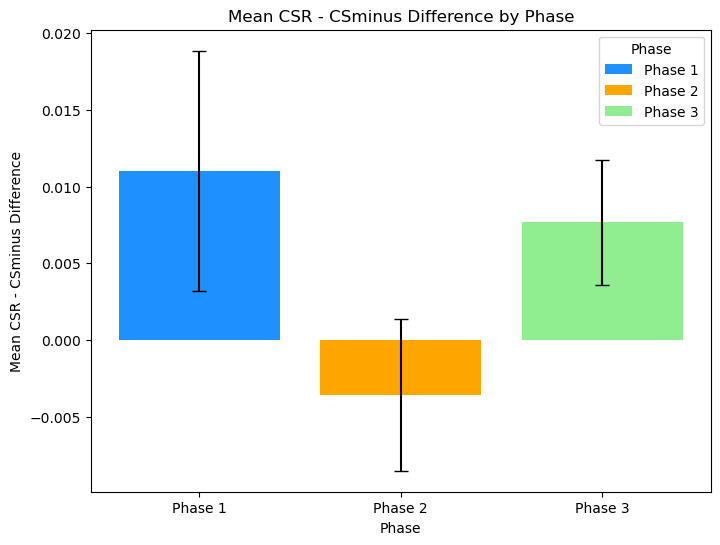

     Phase  t-statistic   p-value
0  Phase 1     1.407294  0.162441
1  Phase 2    -0.719526  0.473495
2  Phase 3     1.869441  0.064487


In [427]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming dat_df and dat_df1 have already been loaded and merged as shown previously
merged_data = pd.merge(dat_df, dat_df1, on='subID', how='inner')

# Calculate the meanCSR - meanCSminus for each phase
merged_data['diff_phase1'] = merged_data['meanCSR1'] - merged_data['meanCSminus1']
merged_data['diff_phase2'] = merged_data['meanCSR2'] - merged_data['meanCSminus2']
merged_data['diff_phase3'] = merged_data['meanCSR3'] - merged_data['meanCSminus3']

# Reshape data for plotting
long_data = pd.melt(merged_data,
                    id_vars=['subID'],
                    value_vars=['diff_phase1', 'diff_phase2', 'diff_phase3'],
                    var_name='phase',
                    value_name='mean_diff')

# Map phase to categorical labels for readability
long_data['phase'] = long_data['phase'].replace({
    'diff_phase1': 'Phase 1',
    'diff_phase2': 'Phase 2',
    'diff_phase3': 'Phase 3'
})

# Perform paired t-tests for CSR vs CSminus in each phase
t_test_results = []
for phase in [1, 2, 3]:
    csr_col = f'meanCSR{phase}'
    csminus_col = f'meanCSminus{phase}'
    t_stat, p_val = stats.ttest_rel(merged_data[csr_col], merged_data[csminus_col])
    t_test_results.append({
        'Phase': f'Phase {phase}',
        't-statistic': t_stat,
        'p-value': p_val
    })

# Create a DataFrame to display t-test results
t_test_df = pd.DataFrame(t_test_results)

# Calculate means and standard errors by phase
group_means = long_data.groupby(['phase'])['mean_diff'].mean().reset_index()
group_sems = long_data.groupby(['phase'])['mean_diff'].sem().reset_index()

# Set up colors for each phase
phase_colors = {
    'Phase 1': 'dodgerblue',
    'Phase 2': 'orange',
    'Phase 3': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(8, 6))

for idx, phase in enumerate(['Phase 1', 'Phase 2', 'Phase 3']):
    # Get data for each phase
    phase_data = group_means[group_means['phase'] == phase]
    phase_errors = group_sems[group_sems['phase'] == phase]
    
    # Plot bar for each phase
    plt.bar(idx, phase_data['mean_diff'].values[0],
            color=phase_colors[phase],
            label=phase,
            yerr=phase_errors['mean_diff'].values[0], capsize=5)

    # # Add significance marker if p-value < 0.05
    # p_val = t_test_df.loc[idx, 'p-value']
    # if p_val < 0.05:
    #     max_y = phase_data['mean_diff'].values[0] + phase_errors['mean_diff'].values[0] + 0.05
    #     plt.text(idx, max_y, '*', ha='center', va='bottom', fontsize=14, color='black')

# Customize plot
plt.xticks([0, 1, 2], ['Phase 1', 'Phase 2', 'Phase 3'])
plt.xlabel('Phase')
plt.ylabel('Mean CSR - CSminus Difference')
plt.title('Mean CSR - CSminus Difference by Phase')
plt.legend(title='Phase')

# Display the 
filename='CSR-CS-_allphases.png'
plt.savefig(filename, format='png', dpi=300)
plt.show()

# Display the table of t-test results
print(t_test_df)


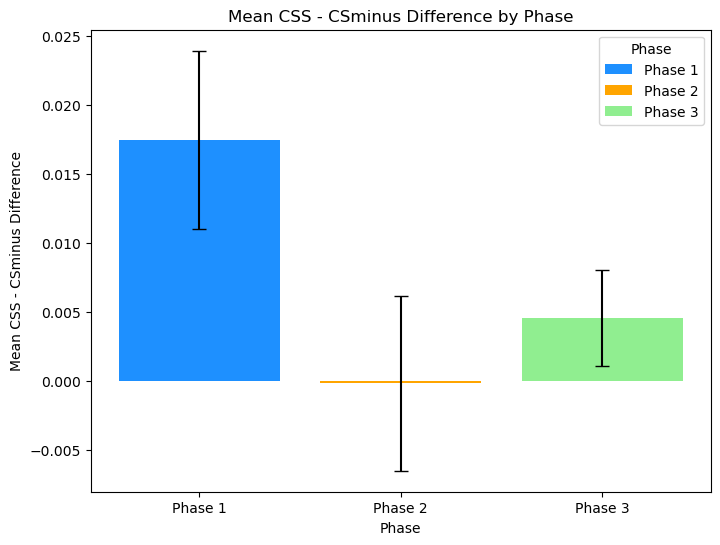

     Phase  t-statistic   p-value
0  Phase 1     2.710033  0.007918
1  Phase 2    -0.028754  0.977118
2  Phase 3     1.297483  0.197450


In [426]:
# CSS vs CSminus

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming dat_df and dat_df1 have already been loaded and merged as shown previously
merged_data = pd.merge(dat_df, dat_df1, on='subID', how='inner')

# Calculate the meanCSR - meanCSminus for each phase
merged_data['diff_phase1'] = merged_data['meanCSS1'] - merged_data['meanCSminus1']
merged_data['diff_phase2'] = merged_data['meanCSS2'] - merged_data['meanCSminus2']
merged_data['diff_phase3'] = merged_data['meanCSS3'] - merged_data['meanCSminus3']

# Reshape data for plotting
long_data = pd.melt(merged_data,
                    id_vars=['subID'],
                    value_vars=['diff_phase1', 'diff_phase2', 'diff_phase3'],
                    var_name='phase',
                    value_name='mean_diff')

# Map phase to categorical labels for readability
long_data['phase'] = long_data['phase'].replace({
    'diff_phase1': 'Phase 1',
    'diff_phase2': 'Phase 2',
    'diff_phase3': 'Phase 3'
})

# Perform paired t-tests for CSR vs CSminus in each phase
t_test_results = []
for phase in [1, 2, 3]:
    csr_col = f'meanCSS{phase}'
    csminus_col = f'meanCSminus{phase}'
    t_stat, p_val = stats.ttest_rel(merged_data[csr_col], merged_data[csminus_col])
    t_test_results.append({
        'Phase': f'Phase {phase}',
        't-statistic': t_stat,
        'p-value': p_val
    })

# Create a DataFrame to display t-test results
t_test_df = pd.DataFrame(t_test_results)

# Calculate means and standard errors by phase
group_means = long_data.groupby(['phase'])['mean_diff'].mean().reset_index()
group_sems = long_data.groupby(['phase'])['mean_diff'].sem().reset_index()

# Set up colors for each phase
phase_colors = {
    'Phase 1': 'dodgerblue',
    'Phase 2': 'orange',
    'Phase 3': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(8, 6))

for idx, phase in enumerate(['Phase 1', 'Phase 2', 'Phase 3']):
    # Get data for each phase
    phase_data = group_means[group_means['phase'] == phase]
    phase_errors = group_sems[group_sems['phase'] == phase]
    
    # Plot bar for each phase
    plt.bar(idx, phase_data['mean_diff'].values[0],
            color=phase_colors[phase],
            label=phase,
            yerr=phase_errors['mean_diff'].values[0], capsize=5)

    # # Add significance marker if p-value < 0.05
    # p_val = t_test_df.loc[idx, 'p-value']
    # if p_val < 0.05:
    #     max_y = phase_data['mean_diff'].values[0] + phase_errors['mean_diff'].values[0] + 0.05
    #     plt.text(idx, max_y, '*', ha='center', va='bottom', fontsize=14, color='black')

# Customize plot
plt.xticks([0, 1, 2], ['Phase 1', 'Phase 2', 'Phase 3'])
plt.xlabel('Phase')
plt.ylabel('Mean CSS - CSminus Difference')
plt.title('Mean CSS - CSminus Difference by Phase')
plt.legend(title='Phase')

# Display the plot
filename='CSS-CS-_allphases.png'
plt.savefig(filename, format='png', dpi=300)
plt.show()

# Display the table of t-test results
print(t_test_df)


In [430]:
# Assuming dat_df and dat_df1 have already been loaded and merged as shown previously
merged_data = pd.merge(dat_df, dat_df1, on='subID', how='inner')

# Calculate CSR - CSminus and CSS - CSminus for each phase
merged_data['CSR_minus_CSminus_phase1'] = merged_data['meanCSR1'] - merged_data['meanCSminus1']
merged_data['CSR_minus_CSminus_phase2'] = merged_data['meanCSR2'] - merged_data['meanCSminus2']
merged_data['CSR_minus_CSminus_phase3'] = merged_data['meanCSR3'] - merged_data['meanCSminus3']

merged_data['CSS_minus_CSminus_phase1'] = merged_data['meanCSS1'] - merged_data['meanCSminus1']
merged_data['CSS_minus_CSminus_phase2'] = merged_data['meanCSS2'] - merged_data['meanCSminus2']
merged_data['CSS_minus_CSminus_phase3'] = merged_data['meanCSS3'] - merged_data['meanCSminus3']


In [435]:
long_data

,subID,condition_phase,mean_diff,condition,phase
0,N101,CSR_minus_CSminus_phase1,0.002750,CSminus,Phase 1
1,N103,CSR_minus_CSminus_phase1,-0.013500,CSminus,Phase 1
2,N104,CSR_minus_CSminus_phase1,-0.007000,CSminus,Phase 1
3,N105,CSR_minus_CSminus_phase1,-0.006000,CSminus,Phase 1
4,N106,CSR_minus_CSminus_phase1,0.001250,CSminus,Phase 1
...,...,...,...,...,...
601,N255,CSS_minus_CSminus_phase3,0.001250,CSminus,Phase 3
602,N257,CSS_minus_CSminus_phase3,-0.003125,CSminus,Phase 3
603,N258,CSS_minus_CSminus_phase3,-0.001375,CSminus,Phase 3
604,N259,CSS_minus_CSminus_phase3,-0.003125,CSminus,Phase 3


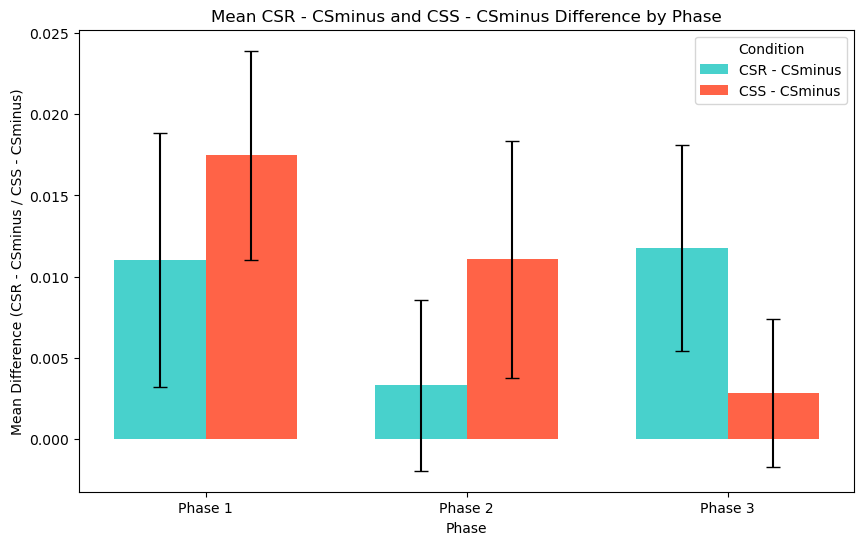

Paired t-test results for CSR - CSminus vs CSS - CSminus in each phase:
     Phase                      Comparison  t-statistic   p-value
0  Phase 1  CSR - CSminus vs CSS - CSminus    -0.890492  0.375339
1  Phase 2  CSR - CSminus vs CSS - CSminus    -1.302559  0.195717
2  Phase 3  CSR - CSminus vs CSS - CSminus     0.804272  0.423148


In [467]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming dat_df and dat_df1 have already been loaded and merged as shown previously
merged_data = pd.merge(dat_df, dat_df1, on='subID', how='inner')

# Calculate CSR - CSminus and CSS - CSminus for each phase
merged_data['CSR_minus_CSminus_phase1'] = merged_data['meanCSR1'] - merged_data['meanCSminus1']
merged_data['CSR_minus_CSminus_phase2'] = merged_data['meanCSR2'] - merged_data['meanCSminus2']
merged_data['CSR_minus_CSminus_phase3'] = merged_data['meanCSR3'] - merged_data['meanCSminus3']

merged_data['CSS_minus_CSminus_phase1'] = merged_data['meanCSS1'] - merged_data['meanCSminus1']
merged_data['CSS_minus_CSminus_phase2'] = merged_data['meanCSS2'] - merged_data['meanCSminus2']
merged_data['CSS_minus_CSminus_phase3'] = merged_data['meanCSS3'] - merged_data['meanCSminus3']

# Merge with 'drug_order' to get drug condition information
merged_data = pd.merge(merged_data, drug_order, left_on='subID', right_on='subID', how='inner')

# Separate data for Phase 1 (all participants) and Phases 2 & 3 (placebo only)
phase1_data = merged_data[['subID', 'CSR_minus_CSminus_phase1', 'CSS_minus_CSminus_phase1']]
phase2_3_data = merged_data[merged_data['drug_condition'] == 0]

# Reshape Phase 1 and Phase 2-3 data for plotting
long_data_phase1 = pd.melt(phase1_data, id_vars=['subID'],
                           value_vars=['CSR_minus_CSminus_phase1', 'CSS_minus_CSminus_phase1'],
                           var_name='condition_phase', value_name='mean_diff')

long_data_phase2_3 = pd.melt(phase2_3_data, id_vars=['subID'],
                             value_vars=['CSR_minus_CSminus_phase2', 'CSR_minus_CSminus_phase3',
                                         'CSS_minus_CSminus_phase2', 'CSS_minus_CSminus_phase3'],
                             var_name='condition_phase', value_name='mean_diff')

# Concatenate Phase 1 and Phase 2-3 data
long_data = pd.concat([long_data_phase1, long_data_phase2_3])

# Separate condition and phase
long_data[['condition', 'phase']] = long_data['condition_phase'].str.extract(r'([^_]+)_minus_CSminus_(phase\d)')
long_data['phase'] = long_data['phase'].replace({
    'phase1': 'Phase 1',
    'phase2': 'Phase 2',
    'phase3': 'Phase 3'
})

# Perform paired t-tests for CSR - CSminus vs CSS - CSminus in each phase
t_test_results = []
for phase in [1, 2, 3]:
    csr_minus_csminus = merged_data[f'CSR_minus_CSminus_phase{phase}']
    css_minus_csminus = merged_data[f'CSS_minus_CSminus_phase{phase}']
    t_stat, p_val = stats.ttest_rel(csr_minus_csminus, css_minus_csminus)
    t_test_results.append({
        'Phase': f'Phase {phase}',
        'Comparison': 'CSR - CSminus vs CSS - CSminus',
        't-statistic': t_stat,
        'p-value': p_val
    })

# Create a DataFrame to display the t-test results
t_test_df = pd.DataFrame(t_test_results)

# Calculate means and standard errors by condition and phase
group_means = long_data.groupby(['condition', 'phase'])['mean_diff'].mean().reset_index()
group_sems = long_data.groupby(['condition', 'phase'])['mean_diff'].sem().reset_index()

# Set up colors for CSR and CSS
condition_colors = {
    'CSR': 'mediumturquoise',
    'CSS': 'tomato'
}

# Plot bar chart
plt.figure(figsize=(10, 6))
x = np.arange(3)  # Positions for the phases on the x-axis

# Width of bars
width = 0.35

# Plot bars for each condition
for idx, condition in enumerate(['CSR', 'CSS']):
    # Get data for each condition
    condition_means = group_means[group_means['condition'] == condition]
    condition_errors = group_sems[group_sems['condition'] == condition]
    
    # Plot bars next to each other within each phase
    plt.bar(x + idx * width, condition_means['mean_diff'], 
            width=width, 
            color=condition_colors[condition],
            label=f'{condition} - CSminus', 
            yerr=condition_errors['mean_diff'], capsize=5)

# Customize plot
plt.xticks(x + width / 2, ['Phase 1', 'Phase 2', 'Phase 3'])
plt.xlabel('Phase')
plt.ylabel('Mean Difference (CSR - CSminus / CSS - CSminus)')
plt.title('Mean CSR - CSminus and CSS - CSminus Difference by Phase')
plt.legend(title='Condition')

# Save and show plot
filename = 'CSR_CSS_CSminus_allphases_fixed.png'
plt.savefig(filename, format='png', dpi=300)
plt.show()

# Display the table of t-test results for CSR - CSminus vs CSS - CSminus
print("Paired t-test results for CSR - CSminus vs CSS - CSminus in each phase:")
print(t_test_df)


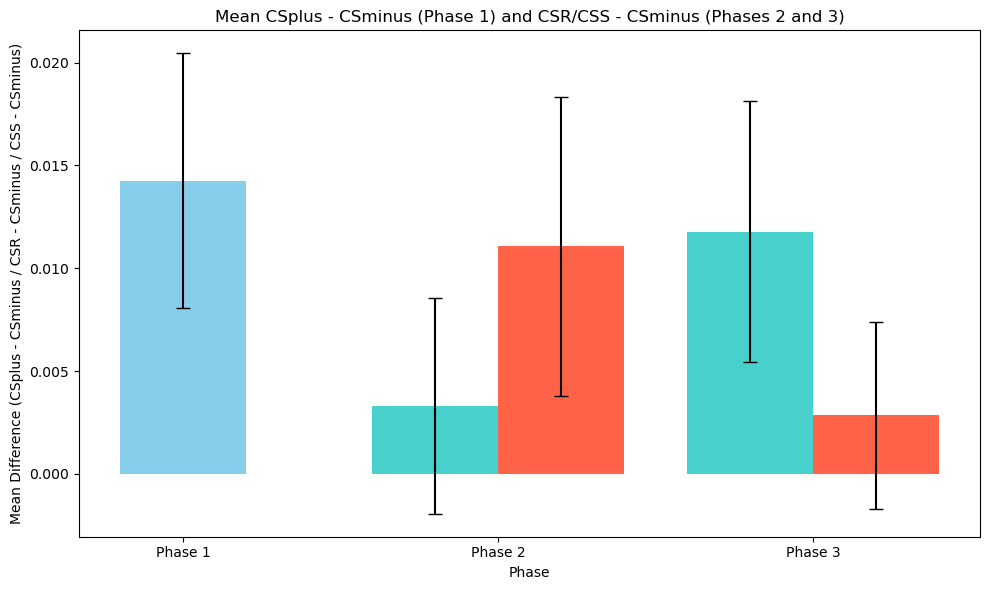

In [461]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming merged_data and drug_order are preloaded as before
merged_data = pd.merge(dat_df, dat_df1, on='subID', how='inner')

# Calculate CSplus (average of CSR and CSS) and CSplus - CSminus for Phase 1
merged_data['CSplus_phase1'] = (merged_data['meanCSR1'] + merged_data['meanCSS1']) / 2
merged_data['CSplus_minus_CSminus_phase1'] = merged_data['CSplus_phase1'] - merged_data['meanCSminus1']

# Calculate CSR - CSminus and CSS - CSminus for Phases 2 and 3 only
merged_data['CSR_minus_CSminus_phase2'] = merged_data['meanCSR2'] - merged_data['meanCSminus2']
merged_data['CSR_minus_CSminus_phase3'] = merged_data['meanCSR3'] - merged_data['meanCSminus3']
merged_data['CSS_minus_CSminus_phase2'] = merged_data['meanCSS2'] - merged_data['meanCSminus2']
merged_data['CSS_minus_CSminus_phase3'] = merged_data['meanCSS3'] - merged_data['meanCSminus3']

# Merge with drug_order to get drug condition information
merged_data = pd.merge(merged_data, drug_order, on='subID', how='inner')

# Separate data for Phase 1 (all participants) and Phases 2 & 3 (placebo only)
phase1_data = merged_data[['subID', 'CSplus_minus_CSminus_phase1']]
phase2_3_data = merged_data[merged_data['drug_condition'] == 0]

# Reshape data for plotting
long_data_phase1 = pd.melt(phase1_data, id_vars=['subID'],
                           value_vars=['CSplus_minus_CSminus_phase1'],
                           var_name='condition_phase', value_name='mean_diff')

long_data_phase2_3 = pd.melt(phase2_3_data, id_vars=['subID'],
                             value_vars=['CSR_minus_CSminus_phase2', 'CSR_minus_CSminus_phase3',
                                         'CSS_minus_CSminus_phase2', 'CSS_minus_CSminus_phase3'],
                             var_name='condition_phase', value_name='mean_diff')

# Concatenate phase 1 and phase 2-3 data
long_data = pd.concat([long_data_phase1, long_data_phase2_3])

# Extract condition and phase
long_data[['condition', 'phase']] = long_data['condition_phase'].str.extract(r'([^_]+)_minus_CSminus_(phase\d)')
long_data['phase'] = long_data['phase'].replace({
    'phase1': 'Phase 1',
    'phase2': 'Phase 2',
    'phase3': 'Phase 3'
})

# Calculate means and standard errors by condition and phase
group_means = long_data.groupby(['condition', 'phase'])['mean_diff'].mean().reset_index()
group_sems = long_data.groupby(['condition', 'phase'])['mean_diff'].sem().reset_index()

# Set colors for CSplus, CSR, and CSS
condition_colors = {
    'CSplus': 'skyblue',
    'CSR': 'mediumturquoise',
    'CSS': 'tomato'
}

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Phases for x-axis positions
x = np.arange(3)

# Width of bars (narrower for reduced spacing)
width = 0.4  

# Plot Phase 1 bar for CSplus only
phase1_means = group_means[(group_means['phase'] == 'Phase 1') & (group_means['condition'] == 'CSplus')]
phase1_sems = group_sems[(group_sems['phase'] == 'Phase 1') & (group_sems['condition'] == 'CSplus')]
if not phase1_means.empty:
    ax.bar(x[0], phase1_means['mean_diff'].values[0], 
           width=width, 
           color=condition_colors['CSplus'],
           label='CSplus - CSminus', 
           yerr=phase1_sems['mean_diff'].values[0], capsize=5)

# Plot Phases 2 and 3 for CSR and CSS with less spacing between bars
for i, condition in enumerate(['CSR', 'CSS']):
    for phase_idx, phase in enumerate(['Phase 2', 'Phase 3']):
        condition_means = group_means[(group_means['phase'] == phase) & (group_means['condition'] == condition)]
        condition_sems = group_sems[(group_sems['phase'] == phase) & (group_means['condition'] == condition)]
        if not condition_means.empty:
            ax.bar(x[phase_idx + 1] + (i - 0.5) * width,  # Shift bars closer within each phase
                   condition_means['mean_diff'].values[0],
                   width=width,
                   color=condition_colors[condition],
                   label=f'{condition} - CSminus' if phase == 'Phase 2' else "",  # Label only once for legend
                   yerr=condition_sems['mean_diff'].values[0], capsize=5)

# Customize plot
ax.set_xticks(x)
ax.set_xticklabels(['Phase 1', 'Phase 2', 'Phase 3'])
ax.set_xlabel('Phase')
ax.set_ylabel('Mean Difference (CSplus - CSminus / CSR - CSminus / CSS - CSminus)')
ax.set_title('Mean CSplus - CSminus (Phase 1) and CSR/CSS - CSminus (Phases 2 and 3)')
# ax.legend(title='Condition')

# Save and show plot
plt.tight_layout()
plt.savefig('CSplus_CSR_CSS_CSminus_allphases_fixed.png', format='png', dpi=300)
plt.show()


In [462]:
t_test_df 

,Phase,Condition,t-statistic,p-value
0,Phase 1,CSR,0.511369,0.611389
1,Phase 1,CSS,1.461961,0.150136
2,Phase 2,CSR,0.631006,0.530969
3,Phase 2,CSS,1.521550,0.134550
4,Phase 3,CSR,1.856332,0.069424
5,Phase 3,CSS,0.622310,0.536623


In [466]:
csplus_minus_csminus = merged_data[f'CSplus_minus_CSminus_phase1']
t_stat, p_val = stats.ttest_rel(merged_data['CSplus_phase1'],merged_data['meanCSminus1'])
p_val

0.02363383508424114